<img src="https://raw.githubusercontent.com/Kmilo29/repository/main/images/proyecto.png" ><br>

# MINE-4101: Ciencia de Datos Aplicada
## Universidad de los Andes
Segundo Semestre - 2023


## Empresa OPAIN S.A.


## Integrantes

* Sebastian Arango Loaiza
* Nicolas Adolfo Castillo Betancourt
* Johan David Rodriguez Portela
* Ivan Camilo Delgado Cañon

# **Limpieza de datos comerciales**

En este notebook se hace un análisis de las dimensiones de calidad de la información proveniente de cada marca y se hace una limpieza preliminar para poder luego hacer el cruce con datos de vuelos de salida.

## Librerias

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Dict, List, Any
import gc
import re

from unidecode import unidecode
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

import univariate_utils, multivariate_utils

## Constantes

In [2]:
# Sales file 1
SALES_FILE_1 = "raw_data/Informacion Bases de datos Comercial Marca 1.xlsx"
# Sales file 2 - 10
SALES_FILE_2_10 = "raw_data/Informacion Bases de datos Comercial Marca 2 - 10.xlsx"

In [3]:
# Names of relevant sale columns
RELEVANT_SALE_COLUMNS = [
    "muelle_venta",
    "fecha_venta",
    "hora_venta",
    "transacciones_venta",
    "valor_venta"
]

In [4]:
# Output file
SALES_OUTPUT_FILE = "data/clean_sales.parquet"

## Utils

In [5]:
def load_excel_sheet(file: str, sheet: str):
    """Loads single excel sheet as a dataframe"""
    return sheet, pd.read_excel(
        file,
        sheet_name=sheet
    )

In [6]:
def load_all_excel_pages(file: str) -> Dict[str, pd.DataFrame]:
    """Reads all excel pages as a dictionary of dataframes"""
    xl = pd.ExcelFile(file)
    sheet_names = xl.sheet_names
    del xl
    gc.collect()
    
    all_pages = dict(
        Parallel(n_jobs=-1, verbose=10)(
            delayed(load_excel_sheet)(
                file, sheet
            )
            for sheet in sheet_names
        )
    )
    return all_pages

In [7]:
def load_sales_data() -> pd.DataFrame:
    """Reads all sales as a dictionary of dataframes"""
    sales_1 = load_all_excel_pages(SALES_FILE_1)
    sales_2 = load_all_excel_pages(SALES_FILE_2_10)
    
    sales_1.update(sales_2)
    
    return sales_1

In [8]:
def clip_data_by_iqr(df, col, strategy, iqr_multiplier):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    bottom_limit = Q1 - iqr_multiplier * IQR
    top_limit = Q3 + iqr_multiplier * IQR
    
    is_low = df[col] <= bottom_limit
    is_high = df[col] >= top_limit
    
    if strategy == "bottom":
        df.loc[is_low, col] = bottom_limit
    if strategy == "top":
        df.loc[is_high, col] = top_limit
    else:
        df.loc[is_low, col] = bottom_limit
        df.loc[is_high, col] = top_limit

In [9]:
def safe_standardize_text(text: str) -> str:
    """Standardizes text to lower and deaccented form"""
    try:
        try:
            is_nan = np.isnan(text)
        except:
            is_nan = text is None
        if is_nan:
            return np.nan
        else:
            return re.sub(
                r"\s+",
                " ",
                re.sub(
                    r'\W+',
                    " ",
                    unidecode(str(text)).lower().strip()
                )
            ).strip()
    except Exception as e:
        print(e)
        return np.nan

In [10]:
def safe_standardize_int(value: Any) -> int:
    """Safely converts value to int"""
    try:
        return np.int64(value)
    except:
        return np.nan

In [11]:
def safe_standardize_float(value: Any) -> float:
    """Safely converts value to float"""
    try:
        return np.float64(value)
    except:
        return np.nan

In [12]:
def safe_standardize_date(date_val: Any) -> pd.Series:
    """Converts a column into a date column"""
    try:
        return date_val.date()
    except:
        return pd.to_datetime(date_val).date()

In [13]:
def merge_sales(sales: Dict[str, pd.DataFrame], relevant_columms: Dict[str, List[str]]) -> pd.DataFrame:
    """Merges all sale info into a single dataframe, grouped hourly by marca and muelle"""
    sales_relevant_info = {
        marca: sales[marca][columns].copy(deep=True)
        for marca, columns in tqdm(relevant_columms.items())
    }
    for marca, df_sales_marca in tqdm(sales_relevant_info.items()):

        df_sales_marca.columns = RELEVANT_SALE_COLUMNS

        df_sales_marca["muelle_venta"] = df_sales_marca["muelle_venta"].apply(
            safe_standardize_text
        )

        df_sales_marca["fecha_venta"] = df_sales_marca["fecha_venta"].apply(
            safe_standardize_date
        )
        df_sales_marca["hora_venta"] = df_sales_marca["hora_venta"].apply(
            safe_standardize_int
        )
        df_sales_marca["transacciones_venta"] = df_sales_marca["transacciones_venta"].apply(
            safe_standardize_int
        )
        df_sales_marca["valor_venta"] = df_sales_marca["valor_venta"].apply(
            safe_standardize_float
        )
        df_sales_marca["marca"] = safe_standardize_text(marca)

            
        # At this point there are no duplicates per marca dataframe
        df_sales_marca = df_sales_marca.groupby([
            "muelle_venta",
            "fecha_venta",
            "hora_venta",
            "marca"
        ]).agg({
            "transacciones_venta": "sum",
            "valor_venta": "sum"
        }).reset_index(drop=False)
        
        df_sales_marca.drop_duplicates(inplace=True)
        


        sales_relevant_info[marca] = df_sales_marca
        

    df_sales = pd.concat(list(sales_relevant_info.values()))
    
    df_sales.drop_duplicates(inplace=True)
    
    return df_sales

In [14]:
def standardize_categories(df: pd.DataFrame, col: str, fixing_map: Dict[Any, Any]) -> None:
    """Standardizes dataframe column categories based on a fix map"""
    df[col] = df[col].apply(
        lambda value: fixing_map[value]
        if value in fixing_map.keys()
        else value
    )

## Ejecucion

### Carga de datos de vuelo y ventas

Como se puede observar la informacion de ventas que se tiene es de 9 marcas diferentes.

In [15]:
sales = load_sales_data()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    2.5s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    2.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    3.0s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    3.1s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    5.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.0min finished


In [16]:
list(sales.keys())

['MARCA 1',
 'Marca 2',
 'Marca 3',
 'Marca 4',
 'Marca 5',
 'Marca 6',
 'Marca 7',
 'marca 8',
 'marca 9',
 'marca 10']

### Analisis de dimensiones de calidad de datos

Se repite el analisis univariado no grafico y grafico por cada marca, con enfasis en el valor de venta para realizar las correcciones necesarias para cada marca. Lo primero a observar es que el formato de las tablas de marca no es estandar, pero lo que todas tienen en comun, excepto por la marca 8 es:
- Muelle
- Fecha
- Hora entera
- Numero de transacciones
- Valor de venta

#### Marca 1
- Menos del 1% de las  filas tienen hora y transacciones vacios. (Dimension de completitud a nivel de atributo) Como la hora no se puede interpolar con los datos actuales se eliminan las filas que sufren de esta condicion. 
- Tiene transacciones negativas, las cuales estan en menos del 1% de las filas. (Dimension de consistencia a nivel de atributo). Se eli|minan las filas con esta propiedad.
- Tiene transacciones con valores de venta extremos, de hasta 159 millones por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Tiene transacciones con valores de numero de transaccion extremos, de hasta 96 por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- No hay duplicados por "Centro de consumo", "Fecha de Venta", "HORA".
- Relevancia, se eliminan columnas innecesarias, para la regresion.

##### Analisis de dimensiones

In [17]:
sales["MARCA 1"].head(3)

,Fecha de Venta,Centro de consumo,Ventas Netas,ZONA,HORA,TRANSACCIONES,SEMANA,Año,Mes,Día,Mes(2)
0,2022-06-15,TIENDA 12,-4878300,MUELLE INTERNACIONAL ORIENTE,23.0,1.0,24,2022,6,15,junio
1,2022-03-18,TIENDA 2,-2841000,MUELLE INTERNACIONAL ORIENTE,0.0,0.0,11,2022,3,18,marzo
2,2023-07-21,TIENDA 4,-2495780,MUELLE INTERNACIONAL ORIENTE,1.0,0.0,29,2023,7,21,julio


In [18]:
univariate_utils.make_not_graphic_analysis(sales["MARCA 1"])

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83370 entries, 0 to 83369
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha de Venta     83370 non-null  datetime64[ns]
 1   Centro de consumo  83370 non-null  object        
 2   Ventas Netas       83370 non-null  int64         
 3   ZONA               83370 non-null  object        
 4   HORA               83282 non-null  float64       
 5   TRANSACCIONES      83282 non-null  float64       
 6   SEMANA             83370 non-null  int64         
 7   Año                83370 non-null  int64         
 8   Mes                83370 non-null  int64         
 9   Día                83370 non-null  int64         
 10  Mes(2)             83370 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 7.0+ MB
----- null percentage -----


Fecha de Venta       0.000000
Centro de consumo    0.000000
Ventas Netas         0.000000
ZONA                 0.000000
HORA                 0.001056
TRANSACCIONES        0.001056
SEMANA               0.000000
Año                  0.000000
Mes                  0.000000
Día                  0.000000
Mes(2)               0.000000
dtype: float64

----- Object column statistics -----


,Centro de consumo,ZONA,Mes(2)
count,83370,83370,83370
unique,10,1,12
top,TIENDA 3,MUELLE INTERNACIONAL ORIENTE,julio
freq,13823,83370,9306


----- Number column statistics -----


,Ventas Netas,HORA,TRANSACCIONES,SEMANA,Año,Mes,Día
count,8.337000e+04,83282.000000,83282.000000,83370.000000,83370.000000,83370.000000,83370.000000
mean,1.257919e+07,11.836603,12.239524,22.946432,2022.325609,5.686314,15.715437
std,1.543836e+07,6.827729,11.354669,14.186395,0.468605,3.242002,8.793854
min,-4.878300e+06,0.000000,0.000000,1.000000,2022.000000,1.000000,1.000000
5%,0.000000e+00,1.000000,0.000000,3.000000,2022.000000,1.000000,2.000000
25%,8.124350e+05,6.000000,1.000000,11.000000,2022.000000,3.000000,8.000000
50%,7.827740e+06,12.000000,10.000000,22.000000,2022.000000,5.000000,16.000000
75%,1.777634e+07,18.000000,19.000000,33.000000,2023.000000,8.000000,23.000000
95%,4.321532e+07,22.000000,34.000000,49.000000,2023.000000,12.000000,29.000000
max,1.598513e+08,23.000000,96.000000,52.000000,2023.000000,12.000000,31.000000


----- First five rows -----


,Fecha de Venta,Centro de consumo,Ventas Netas,ZONA,HORA,TRANSACCIONES,SEMANA,Año,Mes,Día,Mes(2)
0,2022-06-15,TIENDA 12,-4878300,MUELLE INTERNACIONAL ORIENTE,23.0,1.0,24,2022,6,15,junio
1,2022-03-18,TIENDA 2,-2841000,MUELLE INTERNACIONAL ORIENTE,0.0,0.0,11,2022,3,18,marzo
2,2023-07-21,TIENDA 4,-2495780,MUELLE INTERNACIONAL ORIENTE,1.0,0.0,29,2023,7,21,julio
3,2023-06-14,TIENDA 12,-2327660,MUELLE INTERNACIONAL ORIENTE,23.0,7.0,24,2023,6,14,junio
4,2022-09-27,TIENDA 6,-2257140,MUELLE INTERNACIONAL ORIENTE,17.0,1.0,39,2022,9,27,septiembre


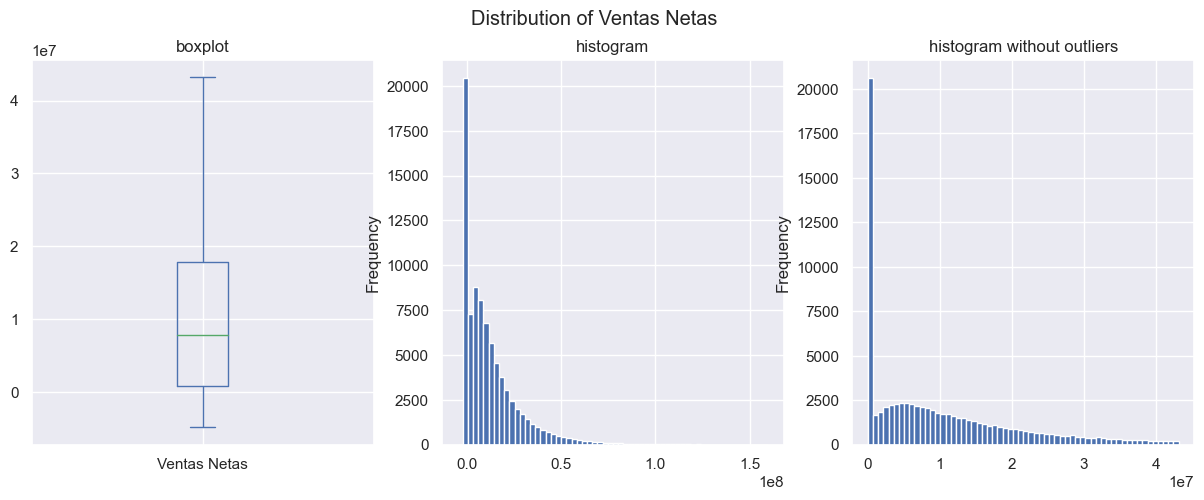

In [19]:
univariate_utils.plot_column_distribution(
        sales["MARCA 1"],
        "Ventas Netas",
        (15,5),
        60
    )

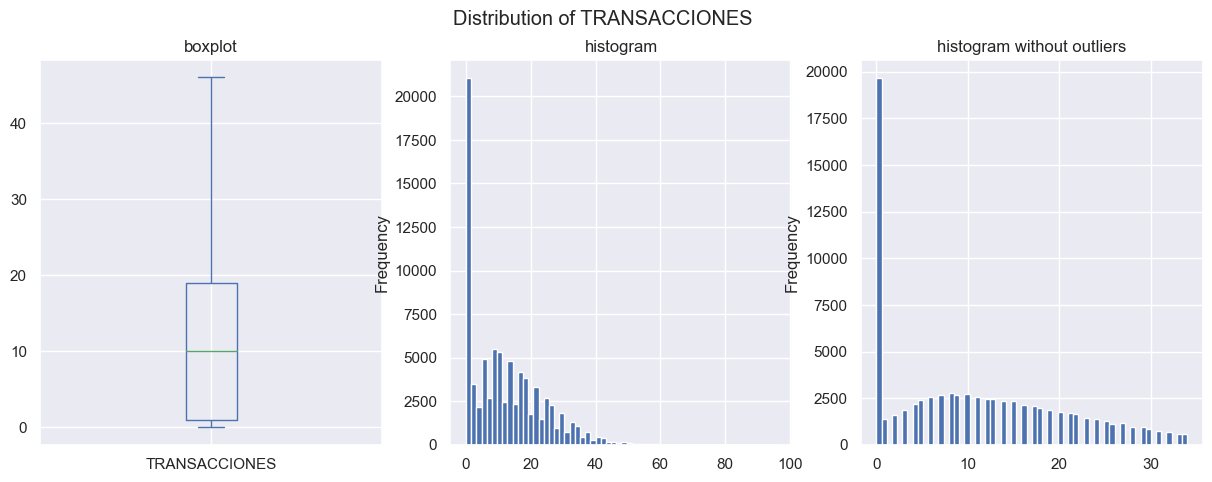

In [20]:
univariate_utils.plot_column_distribution(
        sales["MARCA 1"],
        "TRANSACCIONES",
        (15,5),
        60
    )

In [21]:
sales["MARCA 1"]["Fecha de Venta"].min(), sales["MARCA 1"]["Fecha de Venta"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2023-07-31 00:00:00'))

In [22]:
sum(sales["MARCA 1"]["Ventas Netas"] < 0.0)/len(sales["MARCA 1"]["Ventas Netas"])

0.0004557994482427732

In [23]:
sales["MARCA 1"].groupby(["Centro de consumo", "Fecha de Venta", "HORA"])["Centro de consumo"].count().max()

1

##### Limpieza

In [24]:
sales["MARCA 1"] = sales["MARCA 1"][~sales["MARCA 1"]["HORA"].isnull()].copy(deep=True)

In [25]:
sales["MARCA 1"] = sales["MARCA 1"][~sales["MARCA 1"]["TRANSACCIONES"].isnull()].copy(deep=True)

In [26]:
sales["MARCA 1"] = sales["MARCA 1"][
    sales["MARCA 1"]["Ventas Netas"] >= 0
].copy(deep=True)

In [27]:
clip_data_by_iqr(sales["MARCA 1"], "Ventas Netas", "top", 1.5)

In [28]:
clip_data_by_iqr(sales["MARCA 1"], "TRANSACCIONES", "top", 1.5)

In [29]:
sales["MARCA 1"].columns

Index(['Fecha de Venta', 'Centro de consumo', 'Ventas Netas', 'ZONA', 'HORA',
       'TRANSACCIONES', 'SEMANA', 'Año', 'Mes', 'Día', 'Mes(2)'],
      dtype='object')

In [30]:
sales["MARCA 1"] = sales["MARCA 1"][
    ["ZONA", "Fecha de Venta", "HORA", "TRANSACCIONES", "Ventas Netas"]
].copy(deep=True)

#### Marca 2
- No tiene vacios.
- Tiene transacciones con valores de venta extremos, de hasta 127 millones por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Tiene transacciones con valores de numero de transaccion extremos, de hasta 43 por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- No hay duplicados por "Tienda", "Fecha", "Hora entera".
- Relevancia, se eliminan columnas innecesarias, para la regresion.

##### Analisis de dimensiones

In [31]:
sales["Marca 2"].head(3)

,Tienda,Hora entera,Fecha,Ventas,Transacciones,Unidades,Muelle
0,Tienda B,8,2023-07-01,20000.0,1,0,Internacional Oriente
1,Tienda B,0,2023-07-03,20000.0,1,0,Internacional Oriente
2,Tienda B,18,2023-07-13,20000.0,1,0,Internacional Oriente


In [32]:
univariate_utils.make_not_graphic_analysis(sales["Marca 2"])

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22297 entries, 0 to 22296
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Tienda         22297 non-null  object        
 1   Hora entera    22297 non-null  int64         
 2   Fecha          22297 non-null  datetime64[ns]
 3   Ventas         22297 non-null  float64       
 4   Transacciones  22297 non-null  int64         
 5   Unidades       22297 non-null  int64         
 6   Muelle         22297 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 1.2+ MB
----- null percentage -----


Tienda           0.0
Hora entera      0.0
Fecha            0.0
Ventas           0.0
Transacciones    0.0
Unidades         0.0
Muelle           0.0
dtype: float64

----- Object column statistics -----


,Tienda,Muelle
count,22297,22297
unique,2,1
top,Tienda A,Internacional Oriente
freq,12230,22297


----- Number column statistics -----


,Hora entera,Ventas,Transacciones,Unidades
count,22297.000000,2.229700e+04,22297.000000,22297.000000
mean,13.026237,1.501631e+07,7.861551,14.879849
std,6.245471,1.263133e+07,5.352642,13.673737
min,0.000000,2.000000e+04,1.000000,0.000000
5%,2.000000,1.291088e+06,1.000000,0.000000
25%,8.000000,5.690880e+06,4.000000,4.000000
50%,13.000000,1.180544e+07,7.000000,12.000000
75%,18.000000,2.078400e+07,11.000000,22.000000
95%,22.000000,4.032000e+07,18.000000,42.000000
max,23.000000,1.276681e+08,43.000000,148.000000


----- First five rows -----


,Tienda,Hora entera,Fecha,Ventas,Transacciones,Unidades,Muelle
0,Tienda B,8,2023-07-01,20000.0,1,0,Internacional Oriente
1,Tienda B,0,2023-07-03,20000.0,1,0,Internacional Oriente
2,Tienda B,18,2023-07-13,20000.0,1,0,Internacional Oriente
3,Tienda B,16,2022-01-26,77220.0,1,1,Internacional Oriente
4,Tienda A,18,2023-07-13,84000.0,1,0,Internacional Oriente


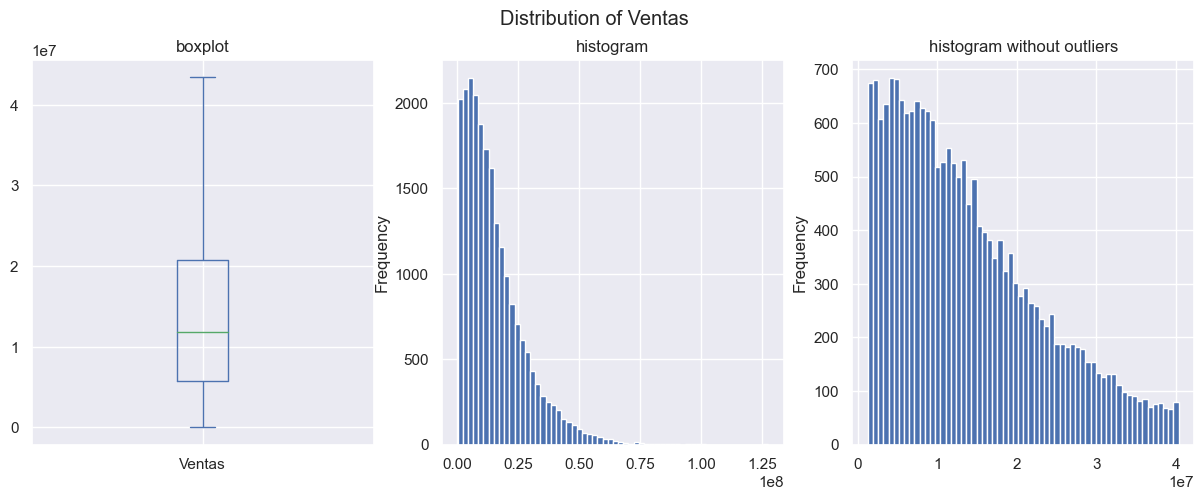

In [33]:
univariate_utils.plot_column_distribution(
        sales["Marca 2"],
        "Ventas",
        (15,5),
        60
    )

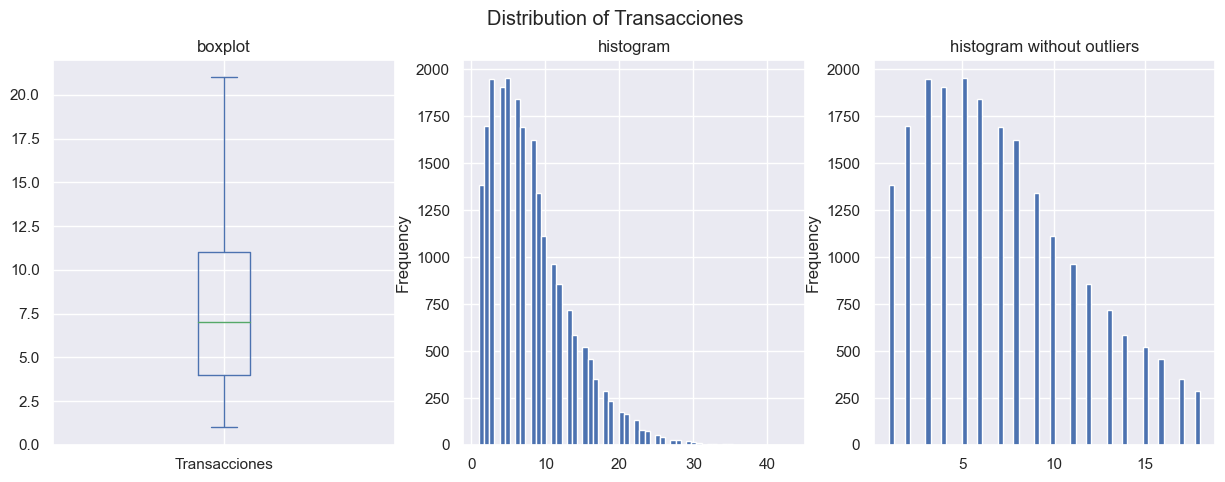

In [34]:
univariate_utils.plot_column_distribution(
        sales["Marca 2"],
        "Transacciones",
        (15,5),
        60
    )

In [35]:
sales["Marca 2"]["Fecha"].min(), sales["Marca 2"]["Fecha"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2023-07-31 00:00:00'))

In [36]:
sales["Marca 2"].groupby(["Tienda", "Fecha", "Hora entera"])["Tienda"].count().max()

1

##### Limpieza

In [37]:
clip_data_by_iqr(sales["Marca 2"], "Ventas", "top", 1.5)

In [38]:
clip_data_by_iqr(sales["Marca 2"], "Transacciones", "top", 1.5)

In [39]:
sales["Marca 2"] = sales["Marca 2"][
    ["Muelle", "Fecha", "Hora entera", "Transacciones", "Ventas"]
].copy(deep=True)

#### Marca 3
- Tiene dos columnas con casi 100% de los datos vacios y con nombre unnamed (Dimension de completitud a nivel de columna). Ninguna de las otras columnas esta vacia.
- Tiene valores de ventas negativos (Dimension de consistencia a nivel de atributo). Se eliminan estas filas dado que son menos del 1%.
- Tiene numero de transacciones negativos (Dimension de consistencia a nivel de atributo). Se eliminan estas filas dado que son menos del 1%.
- Tiene transacciones con valores de venta extremos, de hasta mil millones por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Tiene transacciones con valores de numero de transaccion extremos, de hasta 250 por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Hay duplicados por "Cód tienda", "FECHA", "Hora entera", "VENTAS", "TRANSACCIONES". Se eliminan duplicados con este subset.
- Relevancia, se eliminan columnas innecesarias, para la regresion.

##### Analisis de dimensiones

In [40]:
sales["Marca 3"].head(3)

,Cód tienda,Tipo de tienda,UBICACIÓN,FECHA,VENTAS,Hora entera,TRANSACCIONES,UNIDADES,CATEGORÍA
0,Tienda 2,DUTY FREE,MUELLE INTERNACIONAL CENTRO,2022-03-04,-453281853.4,12,2,0.0,ACCESORIOS
1,Tienda 1,DUTY FREE,MUELLE INTERNACIONAL CENTRO,2023-01-19,-80938967.2,9,2,0.0,LICOR
2,Tienda 1,DUTY FREE,MUELLE INTERNACIONAL CENTRO,2022-09-29,-75545453.4,10,11,-16.0,PERFUMERÍA


In [41]:
univariate_utils.make_not_graphic_analysis(sales["Marca 3"])

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236965 entries, 0 to 236964
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Cód tienda      236965 non-null  object        
 1   Tipo de tienda  236965 non-null  object        
 2   UBICACIÓN       236965 non-null  object        
 3   FECHA           236965 non-null  datetime64[ns]
 4   VENTAS          236965 non-null  float64       
 5   Hora entera     236965 non-null  int64         
 6   TRANSACCIONES   236965 non-null  int64         
 7   UNIDADES        236965 non-null  float64       
 8   CATEGORÍA       236965 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 16.3+ MB
----- null percentage -----


Cód tienda        0.0
Tipo de tienda    0.0
UBICACIÓN         0.0
FECHA             0.0
VENTAS            0.0
Hora entera       0.0
TRANSACCIONES     0.0
UNIDADES          0.0
CATEGORÍA         0.0
dtype: float64

----- Object column statistics -----


,Cód tienda,Tipo de tienda,UBICACIÓN,CATEGORÍA
count,236965,236965,236965,236965
unique,9,2,2,13
top,Tienda 1,DUTY FREE,MUELLE INTERNACIONAL CENTRO,TECNO
freq,61017,149792,146202,45986


----- Number column statistics -----


,VENTAS,Hora entera,TRANSACCIONES,UNIDADES
count,2.369650e+05,236965.000000,236965.000000,2.369650e+05
mean,1.752081e+07,13.306497,5.545714,4.953822e+02
std,4.323312e+07,5.927417,8.525601,1.580398e+04
min,-4.532819e+08,0.000000,-3.000000,-1.600000e+01
5%,2.806722e+05,4.000000,1.000000,1.000000e+00
25%,1.655238e+06,8.000000,1.000000,1.000000e+00
50%,4.977376e+06,13.000000,2.000000,3.000000e+00
75%,1.577096e+07,19.000000,6.000000,1.100000e+01
95%,7.690460e+07,22.000000,22.000000,5.700000e+01
max,3.338912e+09,23.000000,249.000000,2.410714e+06


----- First five rows -----


,Cód tienda,Tipo de tienda,UBICACIÓN,FECHA,VENTAS,Hora entera,TRANSACCIONES,UNIDADES,CATEGORÍA
0,Tienda 2,DUTY FREE,MUELLE INTERNACIONAL CENTRO,2022-03-04,-453281853.4,12,2,0.0,ACCESORIOS
1,Tienda 1,DUTY FREE,MUELLE INTERNACIONAL CENTRO,2023-01-19,-80938967.2,9,2,0.0,LICOR
2,Tienda 1,DUTY FREE,MUELLE INTERNACIONAL CENTRO,2022-09-29,-75545453.4,10,11,-16.0,PERFUMERÍA
3,Tienda 7,DUTY FREE,MUELLE INTERNACIONAL ORIENTE,2022-12-15,-70813397.2,11,1,-2.0,LUJO
4,Tienda 2,DUTY FREE,MUELLE INTERNACIONAL CENTRO,2022-07-25,-56637168.2,12,-3,0.0,ACCESORIOS


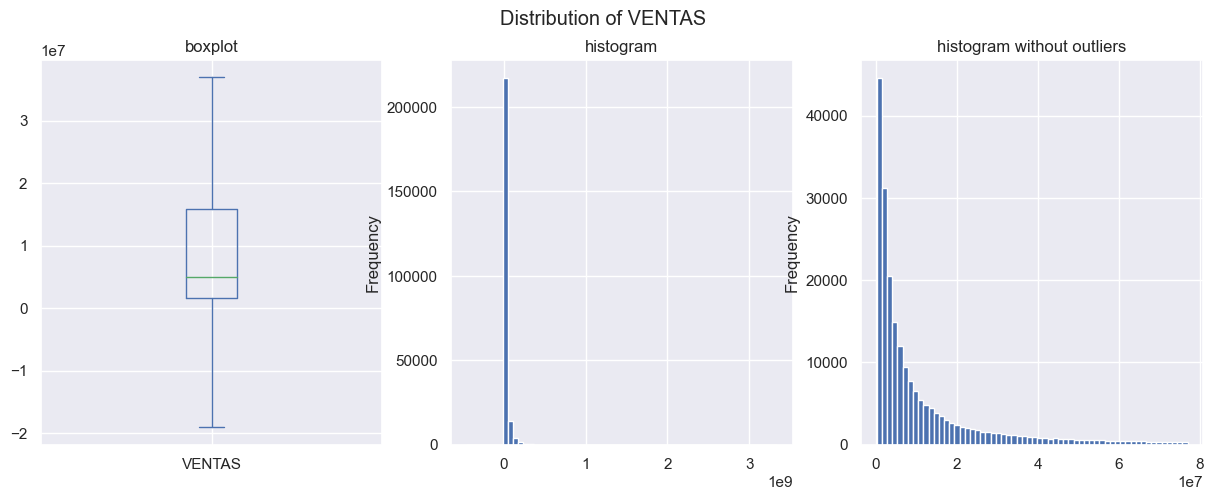

In [42]:
univariate_utils.plot_column_distribution(
        sales["Marca 3"],
        "VENTAS",
        (15,5),
        60
    )

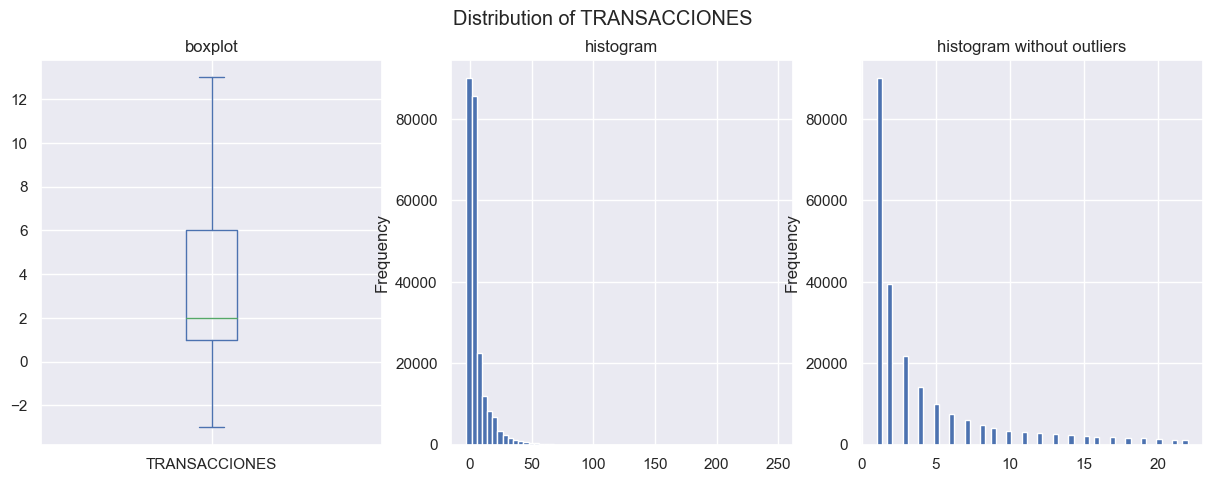

In [43]:
univariate_utils.plot_column_distribution(
        sales["Marca 3"],
        "TRANSACCIONES",
        (15,5),
        60
    )

In [44]:
sales["Marca 3"]["FECHA"].min(), sales["Marca 3"]["FECHA"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2023-07-31 00:00:00'))

In [45]:
sum(sales["Marca 3"]["VENTAS"] < 0.0)/len(sales["Marca 3"]["VENTAS"])

0.0007891460764247885

In [46]:
sum(sales["Marca 3"]["TRANSACCIONES"] < 0.0)/len(sales["Marca 3"]["TRANSACCIONES"])

8.440064988500411e-06

In [47]:
sales["Marca 3"].groupby(["Cód tienda", "FECHA", "Hora entera"])["Cód tienda"].count().max()

14

In [48]:
sales["Marca 3"].groupby(["Cód tienda", "FECHA", "Hora entera", "VENTAS"])["Cód tienda"].count().max()

6

In [49]:
sales["Marca 3"].groupby(["Cód tienda", "FECHA", "Hora entera", "VENTAS", "TRANSACCIONES"])["Cód tienda"].count().max()

6

##### Limpieza

In [50]:
sales["Marca 3"] = sales["Marca 3"][
    sales["Marca 3"]["VENTAS"] >= 0
].copy(deep=True)

In [51]:
sales["Marca 3"] = sales["Marca 3"][
    sales["Marca 3"]["TRANSACCIONES"] >= 0
].copy(deep=True)

In [52]:
clip_data_by_iqr(sales["Marca 3"], "VENTAS", "top", 1.5)

In [53]:
clip_data_by_iqr(sales["Marca 3"], "TRANSACCIONES", "top", 1.5)

In [54]:
sales["Marca 3"].drop_duplicates(
    subset=["Cód tienda", "FECHA", "Hora entera", "VENTAS", "TRANSACCIONES"],
    inplace=True
)

In [55]:
sales["Marca 3"] = sales["Marca 3"][
    ['UBICACIÓN', 'FECHA', 'Hora entera', 'TRANSACCIONES', 'VENTAS']
].copy(deep=True)

#### Marca 4
- La columna CATEGORIA es la unica con vacios, menos del 1% (Dimension de completitud a nivel de atributo). Ninguna de las otras columnas esta vacia.
- Tiene valores de ventas negativos (Dimension de consistencia a nivel de atributo). Se eliminan estas filas dado que son menos del 1%.
- Tiene transacciones con valores de venta extremos, de hasta 10 millones por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Las horas de transaccion parecen binarias, hubo o no hubo transaccion.
- Hay inconsistencias a nivel de fila, como el hecho de que hay transacciones con 0 numero de ventas pero descripcion de venta y precio neto mayor a 0. Por otro lado, las fechas llegan hasta diciembre 2022. **Por ende, se decide ignorar esta marca.**

##### Analisis de dimensiones

In [56]:
sales["Marca 4"].head(3)

,TIENDA1,Muelle,FECHA,HORA,HORA ENTERA,Num fact,TRANSACCIONES,DESCRIPCION,UNIDADES,PRECIO_NETO_LOC,PRECIO_BRUTO_LOC,IMPUESTO_LOC,DESCUENTO_LOC,TOTAL_LOC,CATEGORÍA
0,Tienda 1,Internacional Oriente,2022-01-01,00:09:50.0,0,432990,1,AGUA CRISTAL LITRO,2,11990.0000,11990.0,0.0000,0.0,23980.0,Alimentos y Bebidas Retail
1,Tienda 1,Internacional Oriente,2022-01-01,00:20:36.0,0,432991,1,CHICLE TRIDENT SPLASH YERBABUENA SANDÍA,1,5873.9495,6990.0,1116.0504,0.0,6990.0,Golosinas
2,Tienda 1,Internacional Oriente,2022-01-01,00:20:36.0,0,432991,0,MANZANA CERO PET 500 ML,1,5873.9495,6990.0,1116.0504,0.0,6990.0,Alimentos y Bebidas Retail


In [57]:
univariate_utils.make_not_graphic_analysis(sales["Marca 4"])

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037749 entries, 0 to 1037748
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   TIENDA1           1037749 non-null  object        
 1   Muelle            1037749 non-null  object        
 2   FECHA             1037749 non-null  datetime64[ns]
 3   HORA              1037749 non-null  object        
 4   HORA ENTERA       1037749 non-null  int64         
 5   Num fact          1037749 non-null  int64         
 6   TRANSACCIONES     1037749 non-null  int64         
 7   DESCRIPCION       1037749 non-null  object        
 8   UNIDADES          1037749 non-null  int64         
 9   PRECIO_NETO_LOC   1037749 non-null  float64       
 10  PRECIO_BRUTO_LOC  1037749 non-null  float64       
 11  IMPUESTO_LOC      1037749 non-null  float64       
 12  DESCUENTO_LOC     1037749 non-null  float64       
 13  TOTAL_LOC        

TIENDA1             0.000000
Muelle              0.000000
FECHA               0.000000
HORA                0.000000
HORA ENTERA         0.000000
Num fact            0.000000
TRANSACCIONES       0.000000
DESCRIPCION         0.000000
UNIDADES            0.000000
PRECIO_NETO_LOC     0.000000
PRECIO_BRUTO_LOC    0.000000
IMPUESTO_LOC        0.000000
DESCUENTO_LOC       0.000000
TOTAL_LOC           0.000000
CATEGORÍA           0.029689
dtype: float64

----- Object column statistics -----


,TIENDA1,Muelle,HORA,DESCRIPCION,CATEGORÍA
count,1037749,1037749,1037749,1037749,1006939
unique,3,1,104570,5119,19
top,Tienda 3,Internacional Oriente,13:41:09.0,AGUA CRISTAL 600ML,Alimentos y Bebidas Retail
freq,607977,1037749,79,70330,328407


----- Number column statistics -----


,HORA ENTERA,Num fact,TRANSACCIONES,UNIDADES,PRECIO_NETO_LOC,PRECIO_BRUTO_LOC,IMPUESTO_LOC,DESCUENTO_LOC,TOTAL_LOC
count,1.037749e+06,1.037749e+06,1.037749e+06,1.037749e+06,1.037749e+06,1.037749e+06,1.037749e+06,1.037749e+06,1.037749e+06
mean,1.299222e+01,3.249647e+05,3.681565e-01,1.167658e+00,2.827121e+04,2.911167e+04,4.009183e+03,3.723526e+03,3.259210e+04
std,6.230874e+00,1.692356e+05,4.823044e-01,5.440263e-01,1.671187e+05,1.975799e+05,3.155956e+04,1.132458e+04,1.987500e+05
min,0.000000e+00,1.232500e+04,0.000000e+00,-8.000000e+00,-1.092437e+07,-1.300000e+07,-2.075630e+06,-5.972133e+04,-1.300000e+07
5%,2.000000e+00,1.085730e+05,0.000000e+00,1.000000e+00,5.033613e+03,5.326667e+03,0.000000e+00,0.000000e+00,5.326667e+03
25%,8.000000e+00,1.927090e+05,0.000000e+00,1.000000e+00,7.134454e+03,7.990000e+03,9.563866e+02,0.000000e+00,8.716857e+03
50%,1.300000e+01,2.439340e+05,0.000000e+00,1.000000e+00,1.385714e+04,1.499000e+04,1.795174e+03,0.000000e+00,1.698000e+04
75%,1.900000e+01,4.663390e+05,1.000000e+00,1.000000e+00,3.360504e+04,3.332500e+04,4.526631e+03,3.546783e+03,3.699000e+04
95%,2.200000e+01,6.119380e+05,1.000000e+00,2.000000e+00,7.562185e+04,6.990000e+04,1.037655e+04,1.921580e+04,8.394141e+04
max,2.300000e+01,6.300220e+05,1.000000e+00,2.700000e+01,3.781513e+07,4.500000e+07,7.184874e+06,6.500000e+06,4.500000e+07


----- First five rows -----


,TIENDA1,Muelle,FECHA,HORA,HORA ENTERA,Num fact,TRANSACCIONES,DESCRIPCION,UNIDADES,PRECIO_NETO_LOC,PRECIO_BRUTO_LOC,IMPUESTO_LOC,DESCUENTO_LOC,TOTAL_LOC,CATEGORÍA
0,Tienda 1,Internacional Oriente,2022-01-01,00:09:50.0,0,432990,1,AGUA CRISTAL LITRO,2,11990.0000,11990.0,0.0000,0.0,23980.0,Alimentos y Bebidas Retail
1,Tienda 1,Internacional Oriente,2022-01-01,00:20:36.0,0,432991,1,CHICLE TRIDENT SPLASH YERBABUENA SANDÍA,1,5873.9495,6990.0,1116.0504,0.0,6990.0,Golosinas
2,Tienda 1,Internacional Oriente,2022-01-01,00:20:36.0,0,432991,0,MANZANA CERO PET 500 ML,1,5873.9495,6990.0,1116.0504,0.0,6990.0,Alimentos y Bebidas Retail
3,Tienda 1,Internacional Oriente,2022-01-01,00:23:04.0,0,432992,1,AGUA CRISTAL LITRO,4,11990.0000,11990.0,0.0000,0.0,47960.0,Alimentos y Bebidas Retail
4,Tienda 1,Internacional Oriente,2022-01-01,00:25:01.0,0,432993,1,AGUA CRISTAL 600ML,1,6990.0000,6990.0,0.0000,0.0,6990.0,Alimentos y Bebidas Retail


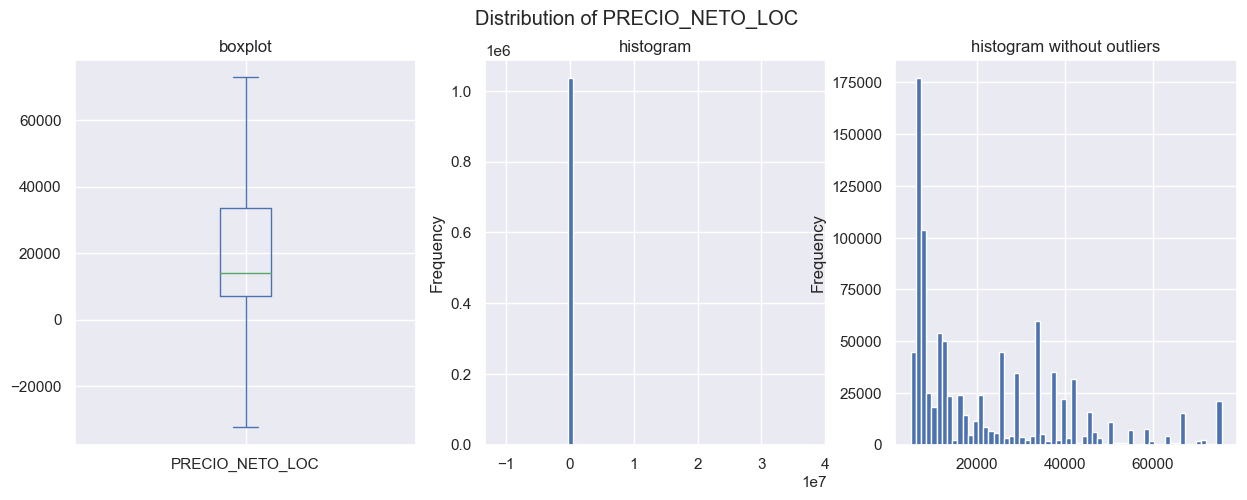

In [58]:
univariate_utils.plot_column_distribution(
        sales["Marca 4"],
        "PRECIO_NETO_LOC",
        (15,5),
        60
    )

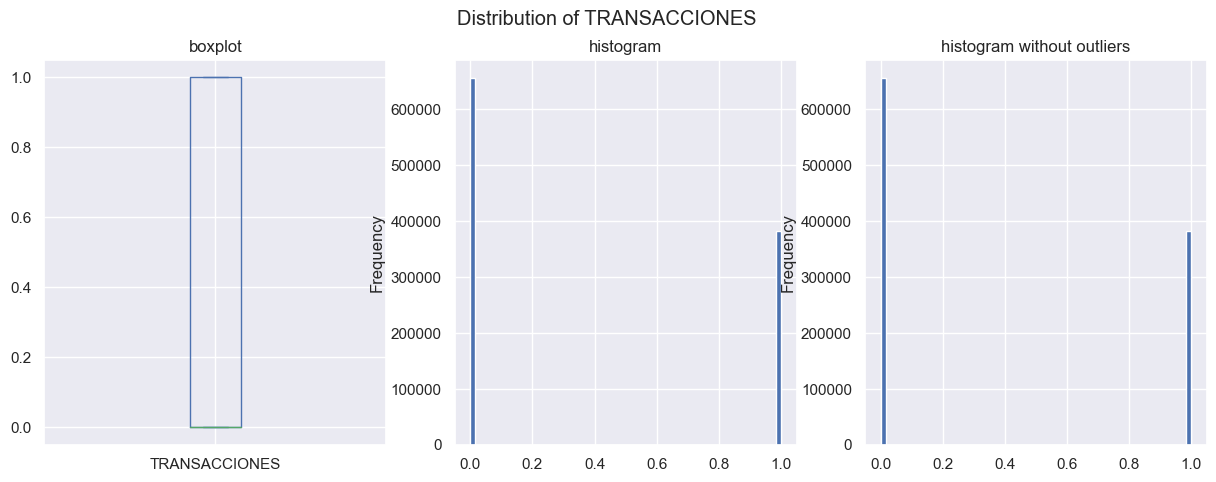

In [59]:
univariate_utils.plot_column_distribution(
        sales["Marca 4"],
        "TRANSACCIONES",
        (15,5),
        60
    )

In [60]:
sales["Marca 4"]["FECHA"].min(), sales["Marca 4"]["FECHA"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'))

In [61]:
sum(sales["Marca 4"]["PRECIO_NETO_LOC"] < 0.0)/len(sales["Marca 4"]["PRECIO_NETO_LOC"])

0.0011312947543192045

In [62]:
sum(sales["Marca 4"]["TRANSACCIONES"] < 0.0)/len(sales["Marca 4"]["TRANSACCIONES"])

0.0

##### Limpieza

In [63]:
sales.pop("Marca 4")

,TIENDA1,Muelle,FECHA,HORA,HORA ENTERA,Num fact,TRANSACCIONES,DESCRIPCION,UNIDADES,PRECIO_NETO_LOC,PRECIO_BRUTO_LOC,IMPUESTO_LOC,DESCUENTO_LOC,TOTAL_LOC,CATEGORÍA
0,Tienda 1,Internacional Oriente,2022-01-01,00:09:50.0,0,432990,1,AGUA CRISTAL LITRO,2,11990.0000,11990.0,0.0000,0.0,23980.0,Alimentos y Bebidas Retail
1,Tienda 1,Internacional Oriente,2022-01-01,00:20:36.0,0,432991,1,CHICLE TRIDENT SPLASH YERBABUENA SANDÍA,1,5873.9495,6990.0,1116.0504,0.0,6990.0,Golosinas
2,Tienda 1,Internacional Oriente,2022-01-01,00:20:36.0,0,432991,0,MANZANA CERO PET 500 ML,1,5873.9495,6990.0,1116.0504,0.0,6990.0,Alimentos y Bebidas Retail
3,Tienda 1,Internacional Oriente,2022-01-01,00:23:04.0,0,432992,1,AGUA CRISTAL LITRO,4,11990.0000,11990.0,0.0000,0.0,47960.0,Alimentos y Bebidas Retail
4,Tienda 1,Internacional Oriente,2022-01-01,00:25:01.0,0,432993,1,AGUA CRISTAL 600ML,1,6990.0000,6990.0,0.0000,0.0,6990.0,Alimentos y Bebidas Retail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037744,Tienda 3,Internacional Oriente,2022-12-31,23:48:55.0,23,260749,0,TE HATSU AZUL 400ML,1,11756.3025,13990.0,2233.6975,0.0,13990.0,Alimentos y Bebidas Retail
1037745,Tienda 3,Internacional Oriente,2022-12-31,23:48:55.0,23,260749,0,AGUA SAN PELLEGRINO PET 500,1,21990.0000,21990.0,0.0000,0.0,21990.0,NaN
1037746,Tienda 3,Internacional Oriente,2022-12-31,23:53:14.0,23,260751,1,CAFÉ COLOMBIA NARINO GRANO 340 GR,2,45704.7619,47990.0,2285.2381,0.0,95980.0,Cafe
1037747,Tienda 3,Internacional Oriente,2022-12-31,23:53:14.0,23,260751,0,QUESO PERA BI X 400G,1,44990.0000,44990.0,0.0000,0.0,44990.0,NaN


#### Marca 5
- Tiene las columnas DESTINO, AEROLINEA y Descripcion de producto con menos del 1% de vacios (Dimension de completitud a nivel de atributo). Como se desea cruzar con muelle se ignoran estos vacios.
- Tiene valores de venta negativos, 
- Tiene transacciones con valores de venta extremos, de hasta 239 millones por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Tiene transacciones con valores de numero de transaccion extremos, de hasta 43 por hora, pero toda la columna esta extranamente centrada en 3. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Violacion de dimension de Consistencia a nivel de fila, ya que hay filas donde el numero de transacciones es cero y las ventas son mayores a cero. Se cambian estas ventas por cero.
- Como no hay informacion de la tienda hay duplicados de "Fecha", "Hora entera", "Ventas". Se eliminan estos duplicados ya que no se diferencian por destino, aerolinea y muelle.
- Relevancia, se eliminan columnas innecesarias, para la regresion.

##### Analisis de dimensiones

In [64]:
sales["Marca 5"].head(3)

,Fecha,Hora entera,Ventas,Transacciones,Unidades,Descripción del producto,DESTINO,AEROLINEA,Muelle
0,2022-12-05,12,50000,3,5,LINEA DE VIAJE,Ciud. Panamá,COPA AIRLINES S.A.,Internacional Oriente
1,2022-08-07,10,56000,3,5,PRENDA,CAMBIO,NaN,Internacional Oriente
2,2022-05-09,12,182000,3,10,LINEA EJECUTIVA,Madrid,IBERIA S.A.,Internacional Oriente


In [65]:
univariate_utils.make_not_graphic_analysis(sales["Marca 5"])

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10972 entries, 0 to 10971
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Fecha                     10972 non-null  datetime64[ns]
 1   Hora entera               10972 non-null  int64         
 2   Ventas                    10972 non-null  int64         
 3   Transacciones             10972 non-null  int64         
 4   Unidades                  10972 non-null  int64         
 5   Descripción del producto  10961 non-null  object        
 6   DESTINO                   10918 non-null  object        
 7   AEROLINEA                 10909 non-null  object        
 8   Muelle                    10972 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 771.6+ KB
----- null percentage -----


Fecha                       0.000000
Hora entera                 0.000000
Ventas                      0.000000
Transacciones               0.000000
Unidades                    0.000000
Descripción del producto    0.001003
DESTINO                     0.004922
AEROLINEA                   0.005742
Muelle                      0.000000
dtype: float64

----- Object column statistics -----


,Descripción del producto,DESTINO,AEROLINEA,Muelle
count,10961,10918,10909,10972
unique,262,121,99,1
top,PEQUEÑA MARROQUINERIA,Miami,AVIANCA S.A,Internacional Oriente
freq,2331,1470,4887,10972


----- Number column statistics -----


,Hora entera,Ventas,Transacciones,Unidades
count,10972.000000,1.097200e+04,10972.000000,10972.000000
mean,13.415968,1.147047e+07,3.003281,6.950419
std,5.118320,1.276365e+07,0.373427,4.525231
min,4.000000,5.000000e+04,0.000000,0.000000
5%,6.000000,7.200000e+05,3.000000,5.000000
25%,10.000000,3.340000e+06,3.000000,5.000000
50%,13.000000,7.980000e+06,3.000000,5.000000
75%,18.000000,1.426000e+07,3.000000,5.000000
95%,22.000000,3.610000e+07,3.000000,15.000000
max,23.000000,2.398000e+08,42.000000,95.000000


----- First five rows -----


,Fecha,Hora entera,Ventas,Transacciones,Unidades,Descripción del producto,DESTINO,AEROLINEA,Muelle
0,2022-12-05,12,50000,3,5,LINEA DE VIAJE,Ciud. Panamá,COPA AIRLINES S.A.,Internacional Oriente
1,2022-08-07,10,56000,3,5,PRENDA,CAMBIO,NaN,Internacional Oriente
2,2022-05-09,12,182000,3,10,LINEA EJECUTIVA,Madrid,IBERIA S.A.,Internacional Oriente
3,2022-02-08,21,280000,3,5,MEDIAS,Madrid,Avianca,Internacional Oriente
4,2022-05-04,12,338000,3,5,ALIMENTO,Ciud. Panamá,AVIANCA S.A,Internacional Oriente


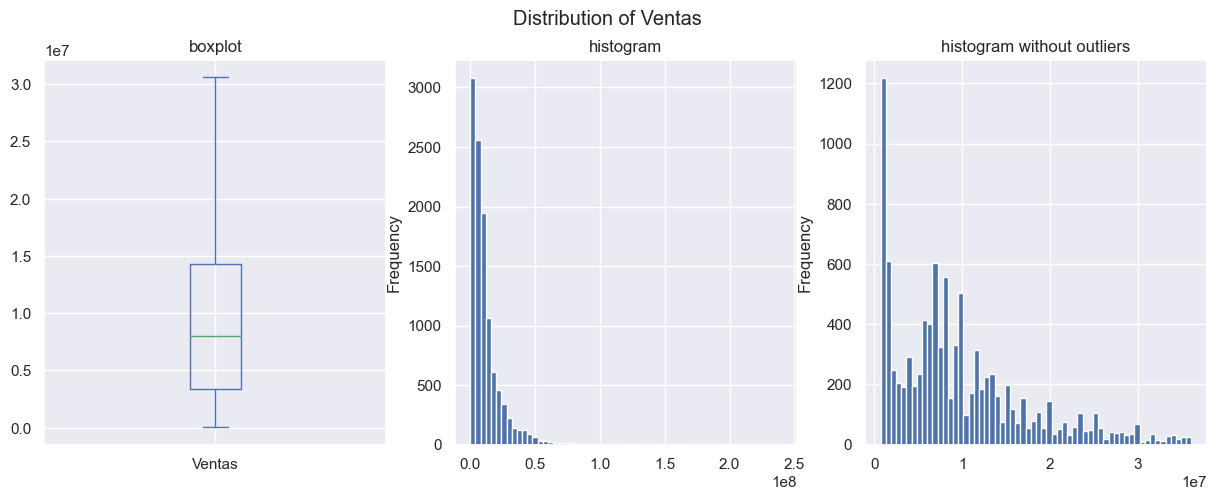

In [66]:
univariate_utils.plot_column_distribution(
        sales["Marca 5"],
        "Ventas",
        (15,5),
        60
    )

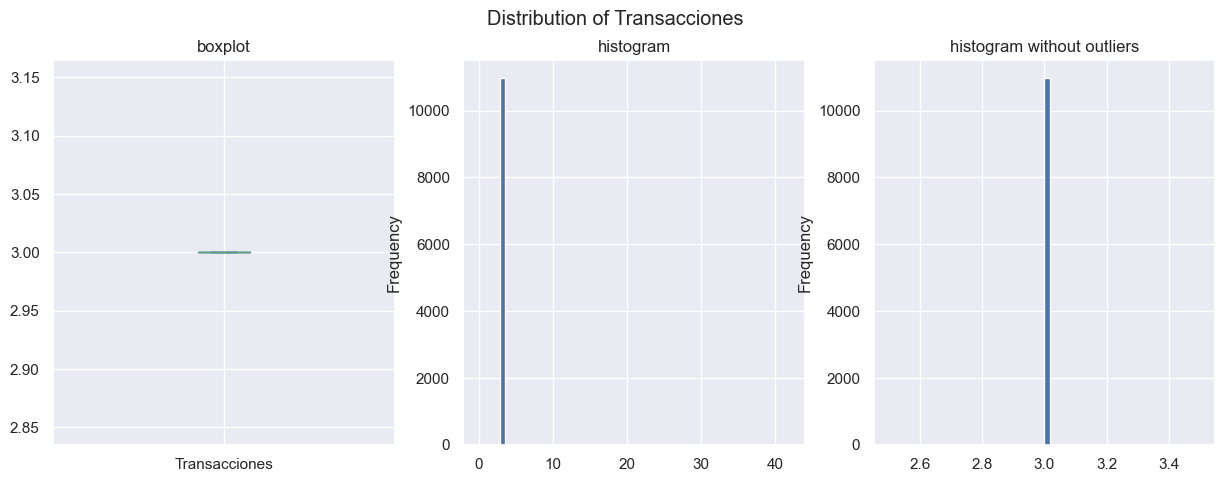

In [67]:
univariate_utils.plot_column_distribution(
        sales["Marca 5"],
        "Transacciones",
        (15,5),
        60
    )

In [68]:
sales["Marca 5"]["Fecha"].min(), sales["Marca 5"]["Fecha"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2023-07-31 00:00:00'))

In [69]:
sales["Marca 5"].groupby(
    ["Fecha", "Hora entera", "Ventas"]
)["Fecha"].count().max()

4

In [70]:
sales["Marca 5"].groupby(
    ["Fecha", "Hora entera", "Ventas", 'DESTINO ', "AEROLINEA", "Muelle"]
)["Fecha"].count().max()

4

##### Limpieza

In [71]:
sales["Marca 5"].columns

Index(['Fecha', 'Hora entera', 'Ventas', 'Transacciones', 'Unidades',
       'Descripción del producto', 'DESTINO ', 'AEROLINEA', 'Muelle'],
      dtype='object')

In [72]:
clip_data_by_iqr(sales["Marca 5"], "Ventas", "top", 1.5)

In [73]:
clip_data_by_iqr(sales["Marca 5"], "Transacciones", "top", 1.5)

In [74]:
is_inconsistent_trans = (sales["Marca 5"]["Ventas"] > 0) & (sales["Marca 5"]["Transacciones"] == 0)
sales["Marca 5"].loc[is_inconsistent_trans, "Ventas"] = 0.0

In [75]:
sales["Marca 5"].drop_duplicates(
    subset=["Fecha", "Hora entera", "Ventas", 'DESTINO ', "AEROLINEA", "Muelle"],
    inplace=True
)

In [76]:
sales["Marca 5"] = sales["Marca 5"][
    ["Muelle", "Fecha", "Hora entera", "Transacciones", "Ventas"]
].copy(deep=True)

#### Marca 6
- Tiene valores de ventas negativos (Dimension de consistencia a nivel de atributo), menores al 1% por lo que se eliminan tales filas.
- Las transacciones (numero) se acumulan en 0 (Dimension de conformidad a nivel de columna) lo cual es inconsistente con las ventas, pero se mantiene ya que el valor de regresion son las ventas. 
- Tiene transacciones con valores de venta extremos, de hasta 236 millones por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Tiene transacciones con valores de numero de transaccion extremos, de hasta 15 por hora, pero toda la columna esta extranamente centrada en 0. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Violacion de dimension de Consistencia a nivel de fila, ya que hay filas donde el numero de transacciones es cero y las ventas son mayores a cero. Se cambian estas ventas por cero. Como casi todos los conteos de transaccion son cero **no se modifica el valor de venta con base en esta condicion**.
- Hay duplicados a nivel de "Fecha", "Hora de venta", "Ventas", "Categoría", "Subcategoría".
- Relevancia, se eliminan columnas innecesarias, para la regresion.

##### Analisis de dimensiones

In [77]:
sales["Marca 6"].head(3)

,Fecha,Categoría,Subcategoría,Hora de venta,Ventas,Unidades,Transacciones,Muelle
0,2022-02-07,Prendas de Vestir,Femenino,14.0,-15000000,0.0,0.0,A Internacional Oriente
1,2022-03-20,Calzado,Femenino,14.0,-1800000,0.0,0.0,A Internacional Oriente
2,2022-05-12,Cinturones,Masculino,21.0,-1200000,0.0,0.0,A Internacional Oriente


In [78]:
univariate_utils.make_not_graphic_analysis(sales["Marca 6"])

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43813 entries, 0 to 43812
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          43813 non-null  datetime64[ns]
 1   Categoría      43806 non-null  object        
 2   Subcategoría   43806 non-null  object        
 3   Hora de venta  43806 non-null  float64       
 4   Ventas         43813 non-null  int64         
 5   Unidades       34669 non-null  float64       
 6   Transacciones  43806 non-null  float64       
 7   Muelle         43813 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 2.7+ MB
----- null percentage -----


Fecha            0.000000
Categoría        0.000160
Subcategoría     0.000160
Hora de venta    0.000160
Ventas           0.000000
Unidades         0.208705
Transacciones    0.000160
Muelle           0.000000
dtype: float64

----- Object column statistics -----


,Categoría,Subcategoría,Muelle
count,43806,43806,43813
unique,10,4,1
top,Sin asignar,Femenino,A Internacional Oriente
freq,9152,16716,43813


----- Number column statistics -----


,Hora de venta,Ventas,Unidades,Transacciones
count,43806.000000,4.381300e+04,34669.000000,43806.000000
mean,13.865315,6.713468e+06,1.510658,0.661302
std,4.972848,8.404888e+06,0.991066,1.610998
min,1.000000,-1.500000e+07,0.000000,0.000000
5%,6.000000,0.000000e+00,1.000000,0.000000
25%,10.000000,1.598000e+06,1.000000,0.000000
50%,13.000000,4.396000e+06,1.000000,0.000000
75%,18.000000,8.638200e+06,2.000000,0.000000
95%,22.000000,2.278800e+07,3.000000,4.000000
max,23.000000,2.365800e+08,36.000000,19.000000


----- First five rows -----


,Fecha,Categoría,Subcategoría,Hora de venta,Ventas,Unidades,Transacciones,Muelle
0,2022-02-07,Prendas de Vestir,Femenino,14.0,-15000000,0.0,0.0,A Internacional Oriente
1,2022-03-20,Calzado,Femenino,14.0,-1800000,0.0,0.0,A Internacional Oriente
2,2022-05-12,Cinturones,Masculino,21.0,-1200000,0.0,0.0,A Internacional Oriente
3,2022-12-26,Marroquinería,Masculino,15.0,-1200000,0.0,0.0,A Internacional Oriente
4,2022-04-25,Bolsos,Femenino,23.0,-1071360,0.0,0.0,A Internacional Oriente


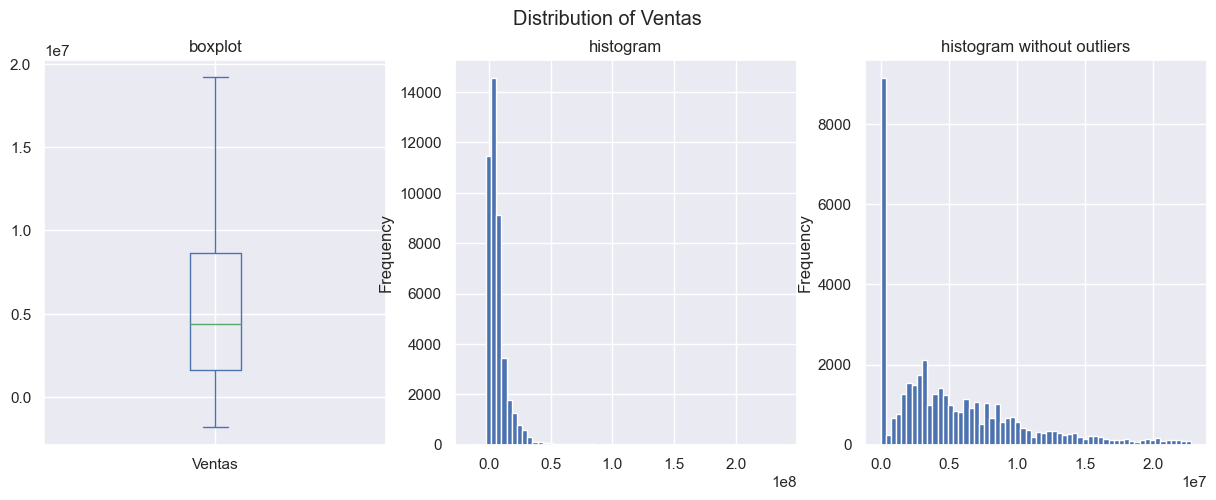

In [79]:
univariate_utils.plot_column_distribution(
        sales["Marca 6"],
        "Ventas",
        (15,5),
        60
    )

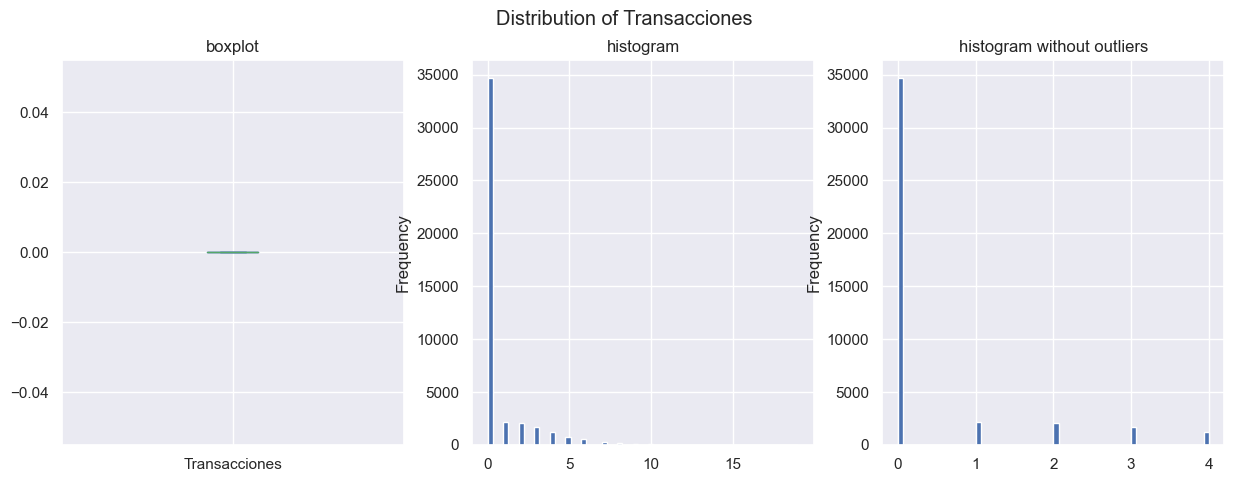

In [80]:
univariate_utils.plot_column_distribution(
        sales["Marca 6"],
        "Transacciones",
        (15,5),
        60
    )

In [81]:
sales["Marca 6"]["Fecha"].min(), sales["Marca 6"]["Fecha"].max()

(Timestamp('2022-01-02 00:00:00'), Timestamp('2023-07-31 00:00:00'))

In [82]:
sum(sales["Marca 6"]["Ventas"] < 0.0)/len(sales["Marca 6"]["Ventas"])

0.00022824275899847076

In [83]:
sales["Marca 6"].groupby(
    ["Fecha", "Hora de venta", "Ventas"]
)["Fecha"].count().max()

4

In [84]:
sales["Marca 6"].groupby(
    ["Fecha", "Hora de venta", "Ventas", "Categoría"]
)["Fecha"].count().max()

2

In [85]:
sales["Marca 6"].groupby(
    ["Fecha", "Hora de venta", "Ventas", "Categoría", "Subcategoría"]
)["Fecha"].count().max()

2

##### Limpieza

In [86]:
sales["Marca 6"] = sales["Marca 6"][sales["Marca 6"]["Ventas"] >= 0.0].copy(deep=True)

In [87]:
clip_data_by_iqr(sales["Marca 6"], "Ventas", "top", 1.5)

In [88]:
clip_data_by_iqr(sales["Marca 6"], "Transacciones", "top", 1.5)

In [89]:
sales["Marca 6"].drop_duplicates(
    subset=["Fecha", "Hora de venta", "Ventas", "Categoría", "Subcategoría"],
    inplace=True
)

In [90]:
sales["Marca 6"] = sales["Marca 6"][
    ["Muelle", "Fecha", "Hora de venta", "Transacciones", "Ventas"]
].copy(deep=True)

#### Marca 7
- Tiene valores de ventas negativos (Dimension de consistencia a nivel de atributo), menores al 1% por lo que se eliminan tales filas.
- Las transacciones (numero) se acumulan en 0 (Dimension de conformidad a nivel de columna) debajo del percentil 25, lo cual es inconsistente con las ventas, pero se mantiene ya que el valor de regresion son las ventas. 
- Tiene transacciones con valores de venta extremos, de hasta 68 millones por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Tiene transacciones con valores de numero de transaccion extremos, de hasta 15 por hora, pero toda la columna esta extranamente centrada en 0. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Violacion de dimension de Consistencia a nivel de fila, ya que hay filas donde el numero de transacciones es cero y las ventas son mayores a cero. Se cambian estas ventas por cero. Como casi todos los conteos de transaccion son cero **no se modifica el valor de venta con base en esta condicion**.
- Hay duplicados a nivel de "Fecha", "Hora", "Venta", "Unidades", "Transacciones".
- Relevancia, se eliminan columnas innecesarias, para la regresion.

##### Analisis de dimensiones

In [91]:
sales["Marca 7"].head(3)

,Fecha,Hora,Personas que ingresan,Venta,Transacciones,Unidades,Muelle
0,2023-04-28,19.0,5.0,-3741176.4,1.0,-2.0,A Internacional oriente
1,2022-05-28,11.0,3.0,-1157983.2,1.0,-1.0,A Internacional oriente
2,2023-05-25,19.0,6.0,-821848.8,1.0,-1.0,A Internacional oriente


In [92]:
univariate_utils.make_not_graphic_analysis(sales["Marca 7"])

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11613 entries, 0 to 11612
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Fecha                  11613 non-null  datetime64[ns]
 1   Hora                   11606 non-null  float64       
 2   Personas que ingresan  11606 non-null  float64       
 3   Venta                  11613 non-null  float64       
 4   Transacciones          11606 non-null  float64       
 5   Unidades               11606 non-null  float64       
 6   Muelle                 11613 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 635.2+ KB
----- null percentage -----


Fecha                    0.000000
Hora                     0.000603
Personas que ingresan    0.000603
Venta                    0.000000
Transacciones            0.000603
Unidades                 0.000603
Muelle                   0.000000
dtype: float64

----- Object column statistics -----


,Muelle
count,11613
unique,1
top,A Internacional oriente
freq,11613


----- Number column statistics -----


,Hora,Personas que ingresan,Venta,Transacciones,Unidades
count,11606.000000,11606.000000,1.161300e+04,11606.000000,11606.000000
mean,13.152163,6.960107,4.663222e+06,1.507496,5.334051
std,6.180631,4.625618,6.292130e+06,1.546043,6.692674
min,0.000000,0.000000,-3.741176e+06,0.000000,-2.000000
5%,4.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,8.000000,4.000000,0.000000e+00,0.000000,0.000000
50%,13.000000,6.000000,2.499160e+06,1.000000,3.000000
75%,18.000000,9.000000,6.749580e+06,2.000000,8.000000
95%,22.000000,15.000000,1.704975e+07,4.000000,19.000000
max,23.000000,51.000000,6.835798e+07,11.000000,69.000000


----- First five rows -----


,Fecha,Hora,Personas que ingresan,Venta,Transacciones,Unidades,Muelle
0,2023-04-28,19.0,5.0,-3741176.4,1.0,-2.0,A Internacional oriente
1,2022-05-28,11.0,3.0,-1157983.2,1.0,-1.0,A Internacional oriente
2,2023-05-25,19.0,6.0,-821848.8,1.0,-1.0,A Internacional oriente
3,2022-01-01,9.0,2.0,0.0,0.0,0.0,A Internacional oriente
4,2022-01-01,18.0,2.0,0.0,0.0,0.0,A Internacional oriente


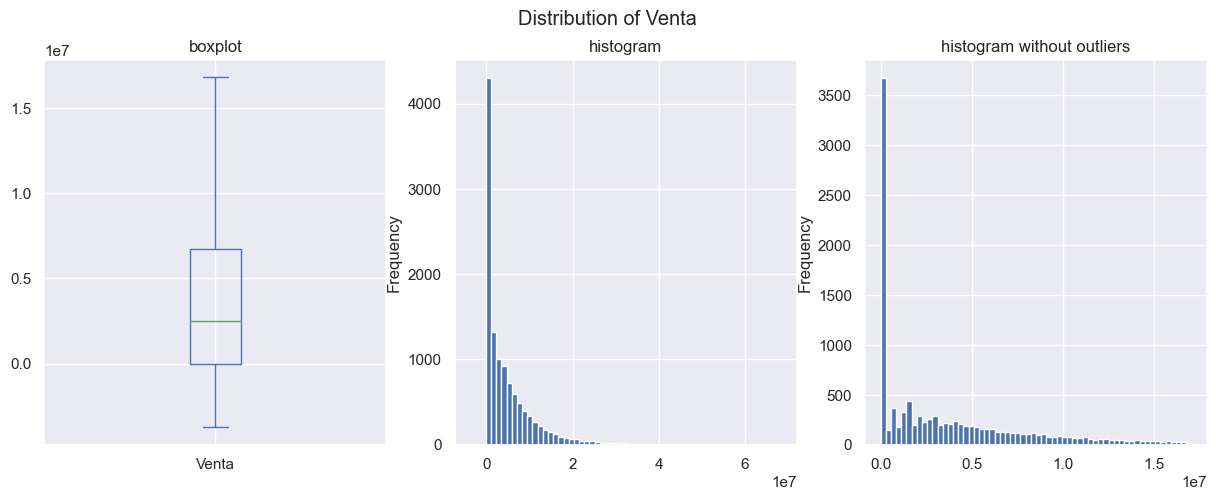

In [93]:
univariate_utils.plot_column_distribution(
        sales["Marca 7"],
        "Venta",
        (15,5),
        60
    )

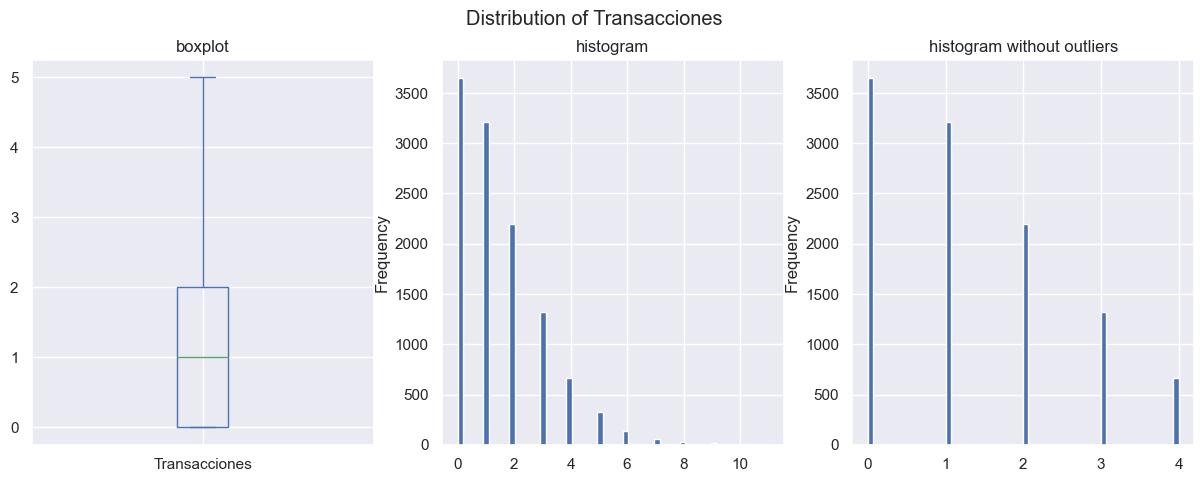

In [94]:
univariate_utils.plot_column_distribution(
        sales["Marca 7"],
        "Transacciones",
        (15,5),
        60
    )

In [95]:
sales["Marca 7"]["Fecha"].min(), sales["Marca 7"]["Fecha"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2023-07-31 00:00:00'))

In [96]:
sum(sales["Marca 7"]["Venta"] < 0.0)/len(sales["Marca 7"]["Venta"])

0.0002583311805734952

In [97]:
sales["Marca 7"].groupby(
    ["Fecha", "Hora", "Venta"]
)["Fecha"].count().max()

10

In [98]:
sales["Marca 7"].groupby(
    ["Fecha", "Hora", "Venta", "Unidades", "Transacciones"]
)["Fecha"].count().max()

10

##### Limpieza

In [99]:
sales["Marca 7"] = sales["Marca 7"][sales["Marca 7"]["Venta"] >= 0.0].copy(deep=True)

In [100]:
clip_data_by_iqr(sales["Marca 7"], "Venta", "top", 1.5)

In [101]:
clip_data_by_iqr(sales["Marca 7"], "Transacciones", "top", 1.5)

In [102]:
sales["Marca 7"].drop_duplicates(
    subset=["Fecha", "Hora", "Venta", "Unidades", "Transacciones"],
    inplace=True
)

In [103]:
sales["Marca 7"] = sales["Marca 7"][
    ["Muelle", "Fecha", "Hora", "Transacciones", "Venta"]
].copy(deep=True)

#### Marca 8
- Dimension de consistencia a nivel de tabla. Como no tiene forma de cruzarse con los vuelos, se elimina esta marca.

In [104]:
sales.pop("marca 8")

,Tienda,Area,Año,Mes,Fecha,Hora entera,# Semana,Ventas,Transacciones,Unidades,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,NaN,NaN,NaN,SEPTIEMBRE,2023-09-03,21:51:00,36,0.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,NaN,NaN,NaN,SEPTIEMBRE,2023-09-04,07:21:00,37,0.0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,NaN,NaN,NaN,SEPTIEMBRE,2023-09-04,07:31:00,37,0.0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,MARCA 8,NaN,2022.0,NOVIEMBRE,2022-11-08,16:38:00,46,200000.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,MARCA 8,NaN,2023.0,JULIO,2023-07-13,18:55:00,29,1800000.0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2926,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2927,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2928,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


#### Marca 9
- Tiene nulos de menos del 1% (Dimension de completitud a nivel de atributo) en Tickets y Piezas. Como tickets es el numero de transacciones se eliminan estas filas.
- Tiene transacciones con valores de venta extremos, de hasta 42 millones por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Tiene transacciones con valores de numero de transaccion extremos, de hasta 399 por hora, pero toda la columna esta extranamente centrada en 0. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- No hay duplicados a nivel de "Fecha", "Hora entera", "Ventas sin IVA ", "TIenda".
- Relevancia, se eliminan columnas innecesarias, para la regresion.

##### Analisis de dimensiones

In [105]:
sales["marca 9"].head(3)

,TIenda,Año,Mes,Fecha,# Semana,Hora entera,Ventas sin IVA,Tickets,Piezas,Muelle
0,MARCA 9,2022,agosto,2022-08-16,33,23,0,NaN,NaN,Internacional Oriente
1,MARCA 9,2022,agosto,2022-08-17,33,23,0,NaN,NaN,Internacional Oriente
2,MARCA 9,2022,septiembre,2022-09-13,37,5,0,NaN,NaN,Internacional Oriente


In [106]:
univariate_utils.make_not_graphic_analysis(sales["marca 9"])

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11255 entries, 0 to 11254
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TIenda           11255 non-null  object        
 1   Año              11255 non-null  int64         
 2   Mes              11255 non-null  object        
 3   Fecha            11255 non-null  datetime64[ns]
 4   # Semana         11255 non-null  int64         
 5   Hora entera      11255 non-null  int64         
 6   Ventas sin IVA   11255 non-null  int64         
 7   Tickets          11211 non-null  float64       
 8   Piezas           11211 non-null  float64       
 9   Muelle           11255 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 879.4+ KB
----- null percentage -----


TIenda             0.000000
Año                0.000000
Mes                0.000000
Fecha              0.000000
# Semana           0.000000
Hora entera        0.000000
Ventas sin IVA     0.000000
Tickets            0.003909
Piezas             0.003909
Muelle             0.000000
dtype: float64

----- Object column statistics -----


,TIenda,Mes,Muelle
count,11255,11255,11255
unique,1,12,1
top,MARCA 9,agosto,Internacional Oriente
freq,11255,1192,11255


----- Number column statistics -----


,Año,# Semana,Hora entera,Ventas sin IVA,Tickets,Piezas
count,11255.000000,11255.000000,11255.000000,1.125500e+04,11211.000000,11211.000000
mean,2022.412261,23.160817,13.605153,9.763632e+06,12.663010,27.537775
std,0.492264,13.899276,5.415090,5.672942e+06,7.602167,17.309614
min,2022.000000,1.000000,4.000000,0.000000e+00,0.000000,0.000000
5%,2022.000000,3.000000,5.000000,1.738982e+06,3.000000,6.000000
25%,2022.000000,11.000000,9.000000,5.578140e+06,8.000000,16.000000
50%,2022.000000,22.000000,14.000000,9.097160e+06,12.000000,26.000000
75%,2023.000000,33.000000,18.000000,1.317943e+07,17.000000,36.000000
95%,2023.000000,48.000000,22.000000,2.007564e+07,23.000000,55.000000
max,2023.000000,52.000000,23.000000,4.256794e+07,399.000000,894.000000


----- First five rows -----


,TIenda,Año,Mes,Fecha,# Semana,Hora entera,Ventas sin IVA,Tickets,Piezas,Muelle
0,MARCA 9,2022,agosto,2022-08-16,33,23,0,NaN,NaN,Internacional Oriente
1,MARCA 9,2022,agosto,2022-08-17,33,23,0,NaN,NaN,Internacional Oriente
2,MARCA 9,2022,septiembre,2022-09-13,37,5,0,NaN,NaN,Internacional Oriente
3,MARCA 9,2022,septiembre,2022-09-16,37,23,0,NaN,NaN,Internacional Oriente
4,MARCA 9,2022,septiembre,2022-09-19,38,23,0,NaN,NaN,Internacional Oriente


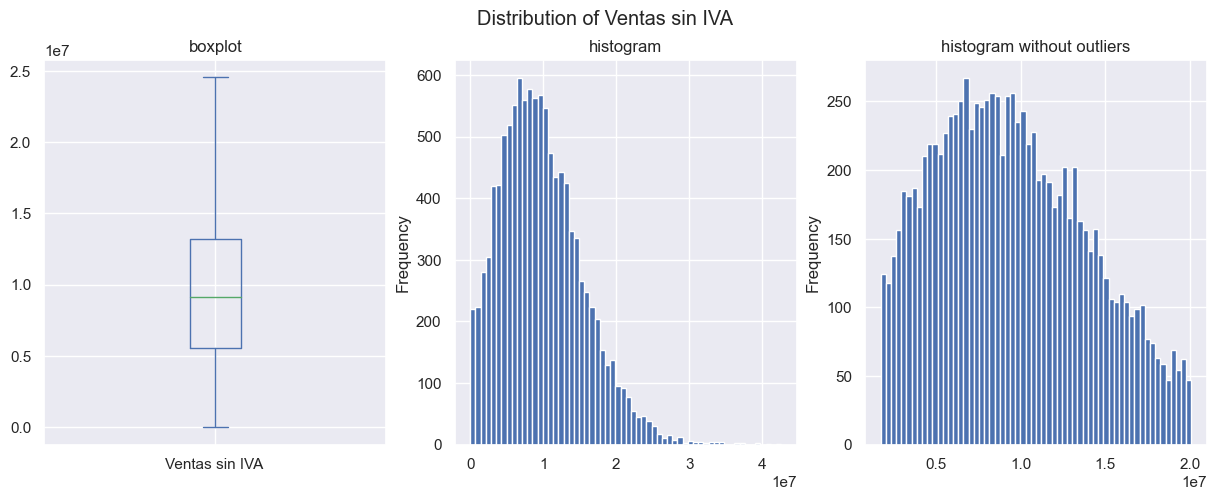

In [107]:
univariate_utils.plot_column_distribution(
        sales["marca 9"],
        'Ventas sin IVA ',
        (15,5),
        60
    )

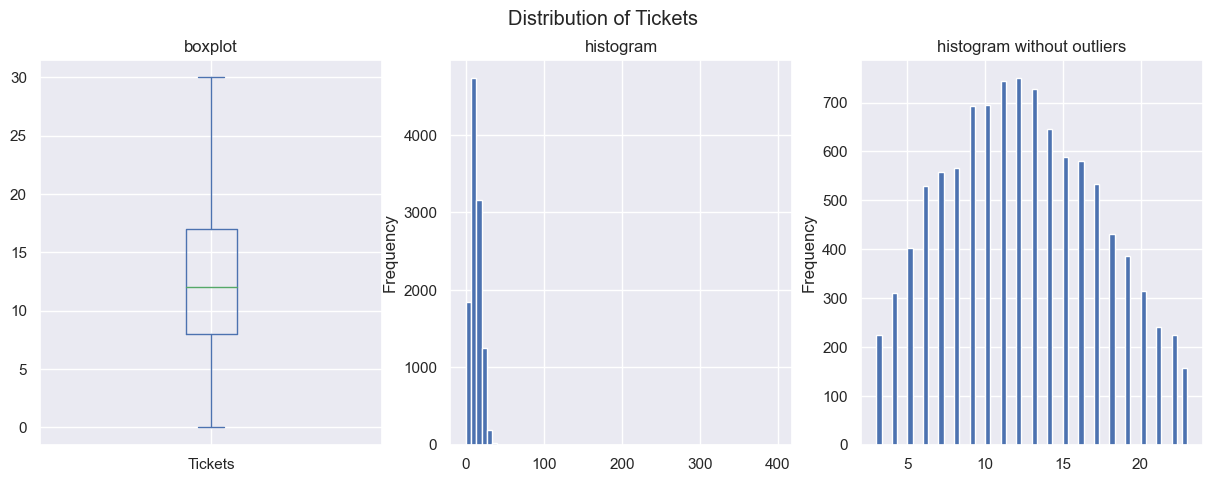

In [108]:
univariate_utils.plot_column_distribution(
        sales["marca 9"],
        "Tickets",
        (15,5),
        60
    )

In [109]:
sales["marca 9"]["Fecha"].min(), sales["marca 9"]["Fecha"].max()

(Timestamp('2022-01-02 00:00:00'), Timestamp('2023-09-03 00:00:00'))

In [110]:
sales["marca 9"].groupby(
    ["Fecha", "Hora entera", "Ventas sin IVA ", "TIenda"]
)["Fecha"].count().max()

1

##### Limpieza

In [111]:
sales["marca 9"] = sales["marca 9"][~sales["marca 9"]["Tickets"].isnull()].copy(deep=True)

In [112]:
clip_data_by_iqr(sales["marca 9"], "Ventas sin IVA ", "top", 1.5)

In [113]:
clip_data_by_iqr(sales["marca 9"], "Tickets", "top", 1.5)

In [114]:
sales["marca 9"].drop_duplicates(
    subset=["Fecha", "Hora entera", "Ventas sin IVA ", "TIenda"],
    inplace=True
)

#### Marca 10
- Tiene ventas negativas en menos del 1% de las filas(Dimension de completitud a nivel de atributo. Se eliminan estas filas.
- Tiene transacciones con valores de venta extremos, de hasta 42 millones por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Las transacciones actuan de forma binaria, por lo que luego se agruparan por hora.
- Hay duplicados a nivel de "Fecha", "Hora entera", "Ventas", "Department".
- Relevancia, se eliminan columnas innecesarias, para la regresion.

##### Analisis de dimensiones

In [115]:
sales["marca 10"].head(3)

,Department,Category,Unidades,Ventas,Total (Tax Ex),Factura,Transacciones,Fecha,Hora,Hora entera,Muelle,Tienda
0,2,Categoria 62,-1,-11182400,-9396974.79,297,1,2022-10-08,18:44:01,18,A Internacional Oriente,marca 10
1,5,Categoria 47,-1,-7886400,-6627226.89,380,1,2022-10-14,22:13:33,22,A Internacional Oriente,marca 10
2,5,Categoria 55,-1,-7872000,-6615126.05,1662,1,2023-03-02,14:52:45,14,A Internacional Oriente,marca 10


In [116]:
univariate_utils.make_not_graphic_analysis(sales["marca 10"])

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4575 entries, 0 to 4574
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Department      4575 non-null   int64         
 1   Category        4575 non-null   object        
 2   Unidades        4575 non-null   int64         
 3   Ventas          4575 non-null   int64         
 4   Total (Tax Ex)  4575 non-null   float64       
 5   Factura         4575 non-null   int64         
 6   Transacciones   4575 non-null   int64         
 7   Fecha           4575 non-null   datetime64[ns]
 8   Hora            4575 non-null   object        
 9   Hora entera     4575 non-null   int64         
 10  Muelle          4575 non-null   object        
 11  Tienda          4575 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 429.0+ KB
----- null percentage -----


Department        0.0
Category          0.0
Unidades          0.0
Ventas            0.0
Total (Tax Ex)    0.0
Factura           0.0
Transacciones     0.0
Fecha             0.0
Hora              0.0
Hora entera       0.0
Muelle            0.0
Tienda            0.0
dtype: float64

----- Object column statistics -----


,Category,Hora,Muelle,Tienda
count,4575,4575,4575,4575
unique,103,2810,1,1
top,Categoria 6,18:54:53,A Internacional Oriente,marca 10
freq,992,23,4575,4575


----- Number column statistics -----


,Department,Unidades,Ventas,Total (Tax Ex),Factura,Transacciones,Hora entera
count,4575.000000,4575.000000,4.575000e+03,4.575000e+03,4575.000000,4575.000000,4575.000000
mean,4.768743,0.980328,4.825110e+06,4.054714e+06,1435.290492,0.896175,14.556503
std,1.497070,0.197398,3.217011e+06,2.703371e+06,834.685496,0.305067,5.026888
min,1.000000,-1.000000,-1.118240e+07,-9.396975e+06,1.000000,0.000000,0.000000
5%,1.000000,1.000000,1.678000e+06,1.410084e+06,132.700000,0.000000,6.000000
25%,4.000000,1.000000,2.830400e+06,2.378487e+06,715.500000,1.000000,11.000000
50%,5.000000,1.000000,3.998000e+06,3.359664e+06,1423.000000,1.000000,15.000000
75%,5.000000,1.000000,5.898000e+06,4.956303e+06,2163.500000,1.000000,19.000000
95%,7.000000,1.000000,1.095840e+07,9.208739e+06,2745.300000,1.000000,22.000000
max,9.000000,1.000000,2.499800e+07,2.100672e+07,2893.000000,1.000000,23.000000


----- First five rows -----


,Department,Category,Unidades,Ventas,Total (Tax Ex),Factura,Transacciones,Fecha,Hora,Hora entera,Muelle,Tienda
0,2,Categoria 62,-1,-11182400,-9396974.790,297,1,2022-10-08,18:44:01,18,A Internacional Oriente,marca 10
1,5,Categoria 47,-1,-7886400,-6627226.890,380,1,2022-10-14,22:13:33,22,A Internacional Oriente,marca 10
2,5,Categoria 55,-1,-7872000,-6615126.050,1662,1,2023-03-02,14:52:45,14,A Internacional Oriente,marca 10
3,5,Categoria 55,-1,-7872000,-6615126.050,1887,1,2023-03-19,21:13:44,21,A Internacional Oriente,marca 10
4,3,Categoria 15,-1,-7518400,-6317983.194,106,1,2022-09-22,12:23:31,12,A Internacional Oriente,marca 10


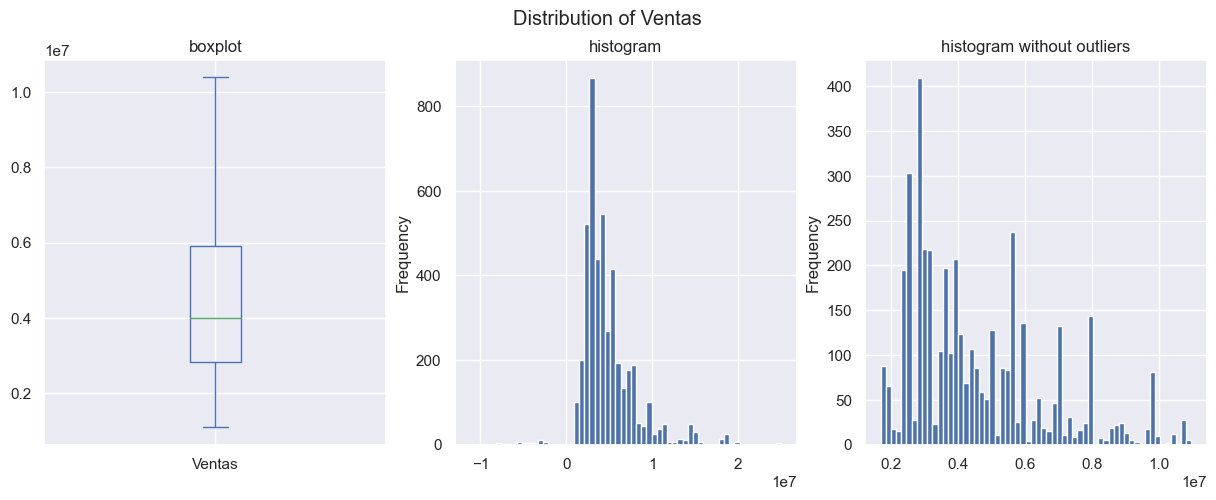

In [117]:
univariate_utils.plot_column_distribution(
        sales["marca 10"],
        'Ventas',
        (15,5),
        60
    )

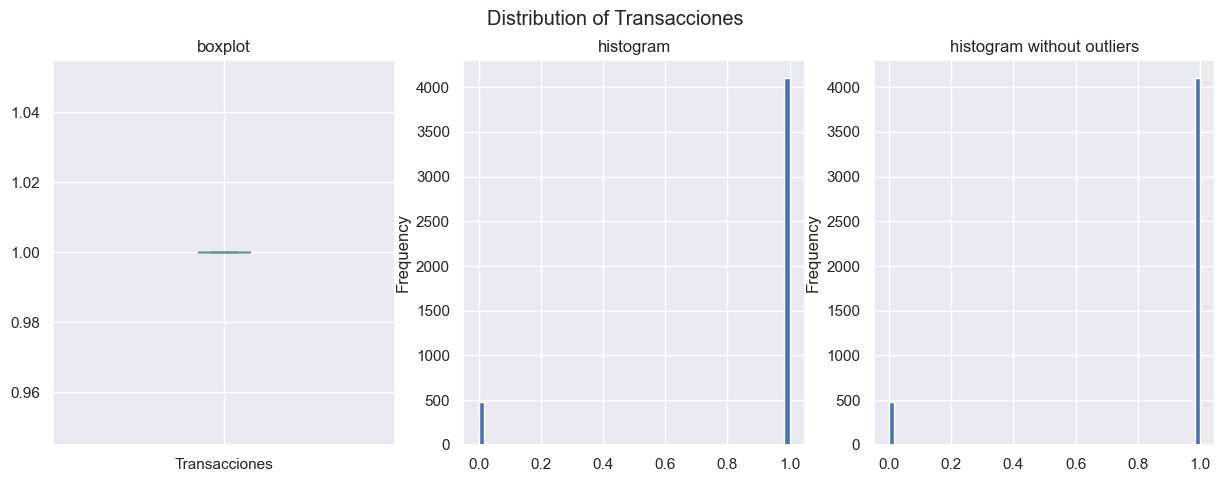

In [118]:
univariate_utils.plot_column_distribution(
        sales["marca 10"],
        "Transacciones",
        (15,5),
        60
    )

In [119]:
sales["marca 10"]["Fecha"].min(), sales["marca 10"]["Fecha"].max()

(Timestamp('2022-09-16 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [120]:
sales["marca 10"].groupby(
    ["Fecha", "Hora entera", "Ventas", "Department"]
)["Fecha"].count().max()

11

##### Limpieza

#### Marca 10
- Tiene ventas negativas en menos del 1% de las filas(Dimension de completitud a nivel de atributo. Se eliminan estas filas.
- Tiene transacciones con valores de venta extremos, de hasta 42 millones por hora. (Dimension de conformidad a nivel de atributo). Se hace clipping de estos valores a 1.5 * IQR.
- Las transacciones actuan de forma binaria, por lo que luego se agruparan por hora.
- Hay duplicados a nivel de "Fecha", "Hora entera", "Ventas", "Department".
- Relevancia, se eliminan columnas innecesarias, para la regresion.

In [121]:
sales["marca 10"] = sales["marca 10"][sales["marca 10"]["Ventas"] >=  0.0].copy(deep=True)

In [122]:
clip_data_by_iqr(sales["marca 10"], "Ventas", "top", 1.5)

In [123]:
sales["marca 10"].drop_duplicates(
    subset=["Fecha", "Hora entera", "Ventas", "Department"],
    inplace=True
)

In [124]:
sales["marca 10"] = sales["marca 10"][
    ["Muelle", "Fecha", "Hora entera", "Transacciones", "Ventas"]
].copy(deep=True)

### Union de marcas de ventas

Se unen todas las ventas de las marcas en un unico dataframe con columnas estandarizadas:
- "muelle_venta": Muelle donde se realizo la venta
- "fecha_venta": Fecha YYYY-MM-DD en que se realizo la venta
- "hora_venta": Hora entera (0 a 23)  en que se realizo la venta
- "transacciones_venta": Numero de transacciones en un momento determinado para la marca
- "valor_venta": Monto generado por transacciones en un momento determinado para la marca

In [125]:
relevant_sales_columns = {
    "MARCA 1": ["ZONA", "Fecha de Venta", "HORA", "TRANSACCIONES", "Ventas Netas"],
    "Marca 2": ["Muelle", "Fecha", "Hora entera", "Transacciones", "Ventas"],
    "Marca 3": ["UBICACIÓN", "FECHA", "Hora entera", "TRANSACCIONES", "VENTAS"],
    "Marca 5": ["Muelle", "Fecha", "Hora entera", "Transacciones", "Ventas"],
    "Marca 6": ["Muelle", "Fecha", "Hora de venta", "Transacciones", "Ventas"],
    "Marca 7": ["Muelle", "Fecha", "Hora", "Transacciones", "Venta"],
    "marca 9": ["Muelle", "Fecha", "Hora entera", "Tickets", "Ventas sin IVA "],
    "marca 10": ["Muelle", "Fecha", "Hora entera", "Transacciones", "Ventas"]
}

In [126]:
df_sales = merge_sales(sales, relevant_sales_columns)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.36it/s]


### Estandarizacion de muelle
Atendiendo a la dimension de conformidad por atributo, se reemplaza el muelle por valores estandar.

In [127]:
fix_muelle = {
    'internacional oriente': 'muelle internacional oriente',
    'a internacional oriente': 'muelle internacional oriente',
}

In [128]:
standardize_categories(df_sales, "muelle_venta", fix_muelle)

### Analisis bivariado de marcas vs transaccion y valor de venta (Repeticion del EDA pero con mejor limpieza por marca)
Se visualiza en formato de histograma, boxplot y serie de tiempo si las marcas tienen comportamientos de valores diferentes.

De las marcas se observa que la 1 y la 2 son muy superiores a las demas en valores de ventas con un percentil 25 superior a 20 millones de pesos por hora, y esto se da porque tienen valores altos que son extremos, dada la distribucion multimodal que presentan despues del clipping. Esto podria indicar que aun es necesario verificar los datos con el cliente.


De las series de tiempo se observa que hay patrones regulares en donde unas marcas casi siempre tienen mayores de ventas que otras. Lo mismo sucede con las transacciones y se presenta cierta estacionalidad, con patrones repetitivos que indican que se podria usar forecasting si se tuviesen valores actualizados cada cierto tiempo. 

In [129]:
multivariate_utils.make_column_non_graphic_analysis(
    df_sales,
    "valor_venta",
    "marca"   
)

marca,marca 1,marca 10,marca 2,marca 3,marca 5,marca 6,marca 7,marca 9
count,1.381500e+04,2.031000e+03,1.281900e+04,2.425200e+04,6.181000e+03,9.123000e+03,1.137500e+04,1.121100e+04
mean,7.073917e+07,9.324557e+06,2.543155e+07,9.750915e+07,1.794949e+07,2.855140e+07,4.366895e+06,9.749784e+06
std,5.637602e+07,7.316092e+06,1.855712e+07,6.995738e+07,1.624484e+07,2.223222e+07,5.309287e+06,5.480635e+06
min,0.000000e+00,1.342400e+06,8.712000e+04,0.000000e+00,3.840000e+05,0.000000e+00,0.000000e+00,0.000000e+00
5%,5.892316e+06,2.518600e+06,2.218192e+06,9.494524e+06,7.200000e+05,3.396200e+06,0.000000e+00,1.843690e+06
25%,2.423821e+07,3.998000e+06,1.066863e+07,3.651725e+07,6.580000e+06,1.119600e+07,0.000000e+00,5.612020e+06
50%,5.589818e+07,7.038400e+06,2.146800e+07,8.138554e+07,1.296000e+07,2.318800e+07,2.517647e+06,9.121020e+06
75%,1.056855e+08,1.176170e+07,3.661070e+07,1.534599e+08,2.672000e+07,4.019500e+07,6.815123e+06,1.319662e+07
95%,1.827371e+08,2.461600e+07,6.133666e+07,2.223843e+08,4.928000e+07,7.157785e+07,1.687395e+07,2.009687e+07
max,2.702835e+08,5.038260e+07,8.684736e+07,3.436570e+08,1.367400e+08,1.558566e+08,8.900672e+07,2.457352e+07


In [130]:
multivariate_utils.make_column_non_graphic_analysis(
    df_sales,
    "transacciones_venta",
    "marca"   
)

marca,marca 1,marca 10,marca 2,marca 3,marca 5,marca 6,marca 7,marca 9
count,13815.000000,2031.000000,12819.000000,24252.000000,6181.000000,9123.0,11375.000000,11211.000000
mean,73.482591,1.934515,13.527186,37.952293,5.170523,0.0,1.491868,12.587726
std,49.367986,1.380064,8.215564,18.552414,3.004965,0.0,1.583750,6.025981
min,0.000000,1.000000,1.000000,1.000000,3.000000,0.0,0.000000,0.000000
5%,10.000000,1.000000,2.000000,12.000000,3.000000,0.0,0.000000,3.000000
25%,35.000000,1.000000,7.000000,23.000000,3.000000,0.0,0.000000,8.000000
50%,63.000000,1.000000,12.000000,34.000000,3.000000,0.0,1.000000,12.000000
75%,104.000000,2.000000,19.000000,53.000000,6.000000,0.0,2.000000,17.000000
95%,167.000000,5.000000,29.000000,71.000000,12.000000,0.0,5.000000,23.000000
max,256.000000,10.000000,42.000000,108.000000,24.000000,0.0,33.000000,30.000000


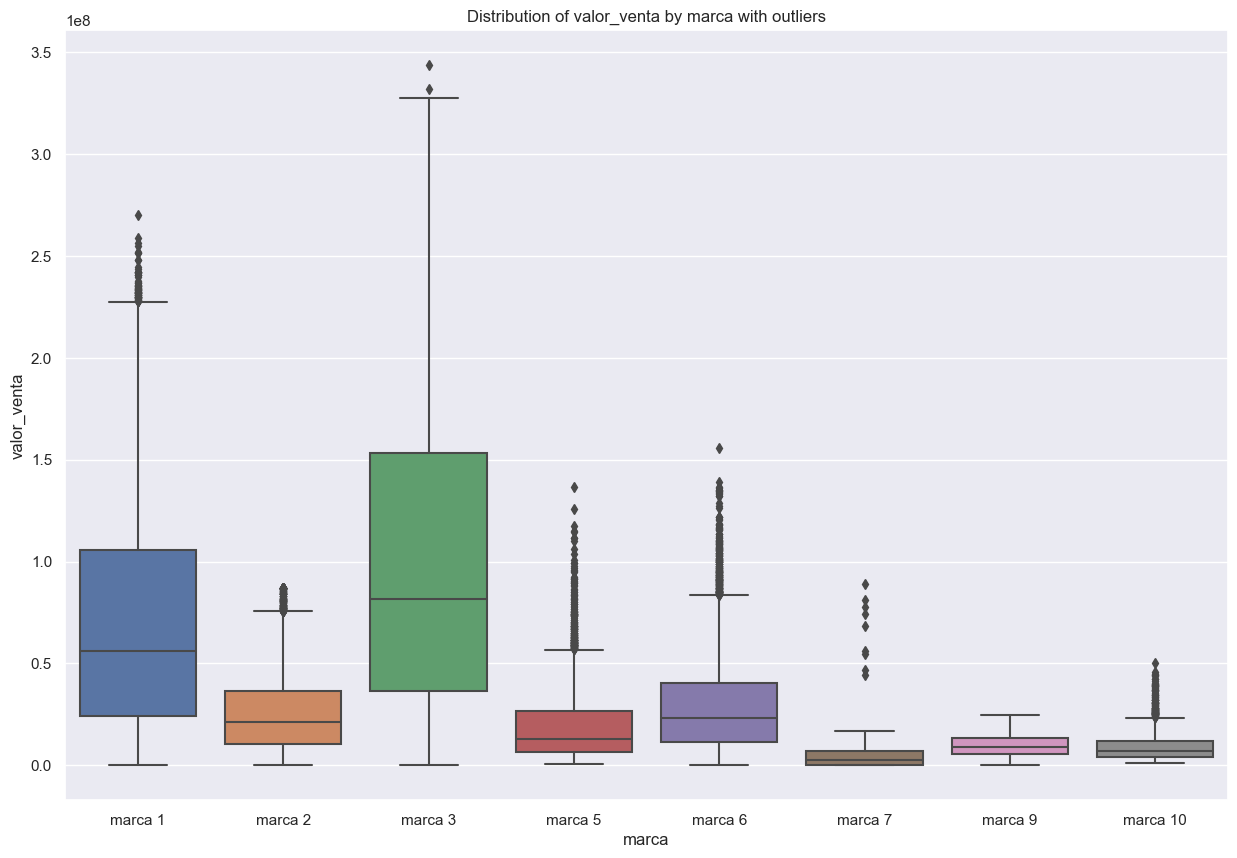

In [131]:
multivariate_utils.plot_distributions(
    df_sales,
    "valor_venta",
    "marca",  # Puede ser None si no hay categorias
    (15, 10),
    "box",  # Puede ser hist o box
    True
)

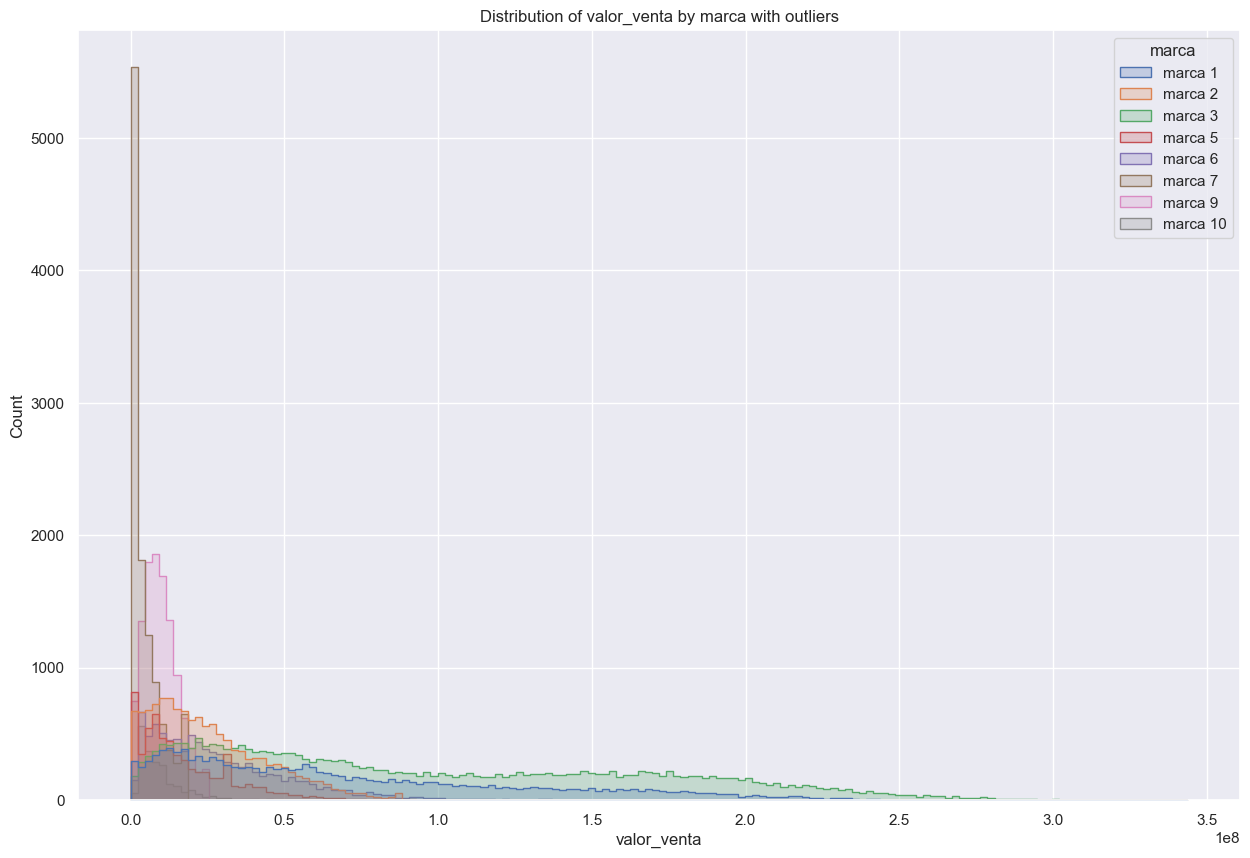

In [132]:
multivariate_utils.plot_distributions(
    df_sales,
    "valor_venta",
    "marca",  # Puede ser None si no hay categorias
    (15, 10),
    "hist",  # Puede ser hist o box
    True
)

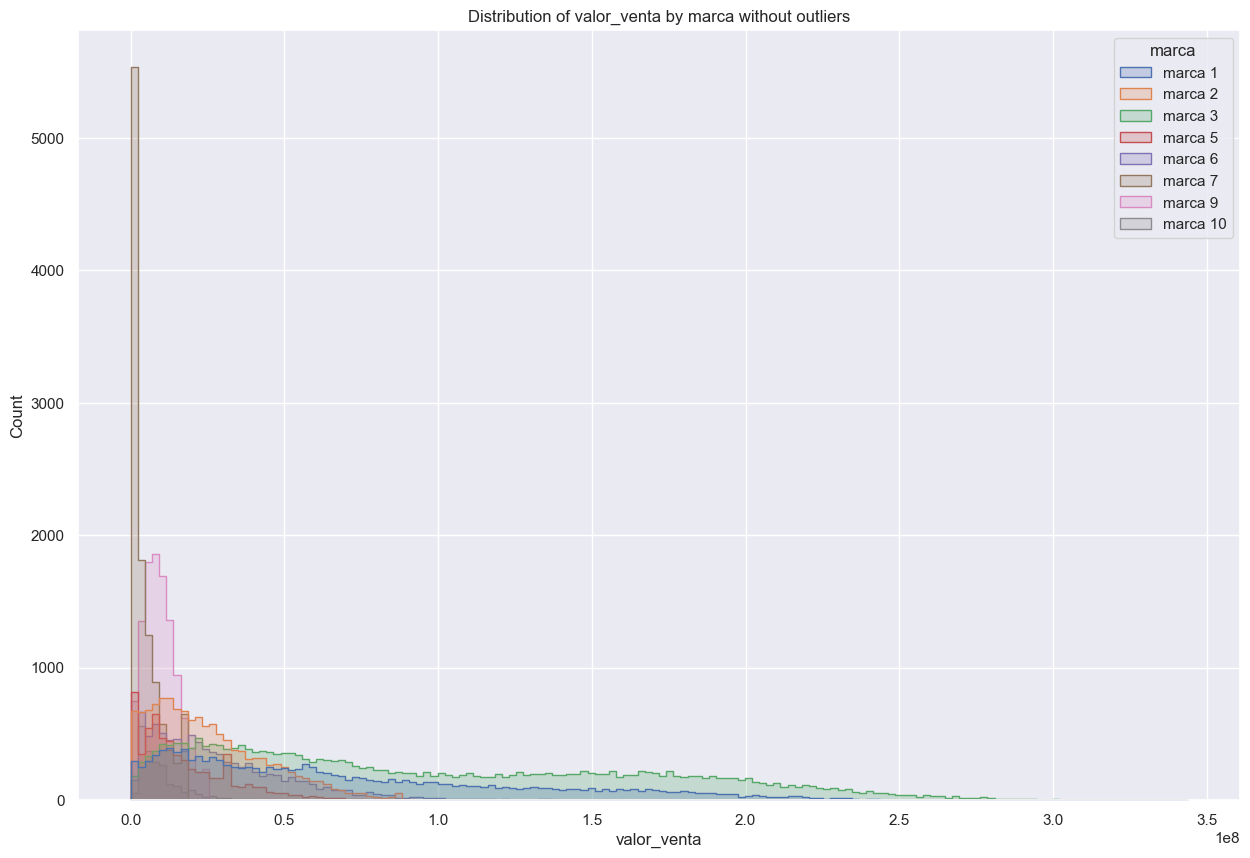

In [133]:
multivariate_utils.plot_distributions(
    df_sales,
    "valor_venta",
    "marca",  # Puede ser None si no hay categorias
    (15, 10),
    "hist",  # Puede ser hist o box
    False
)

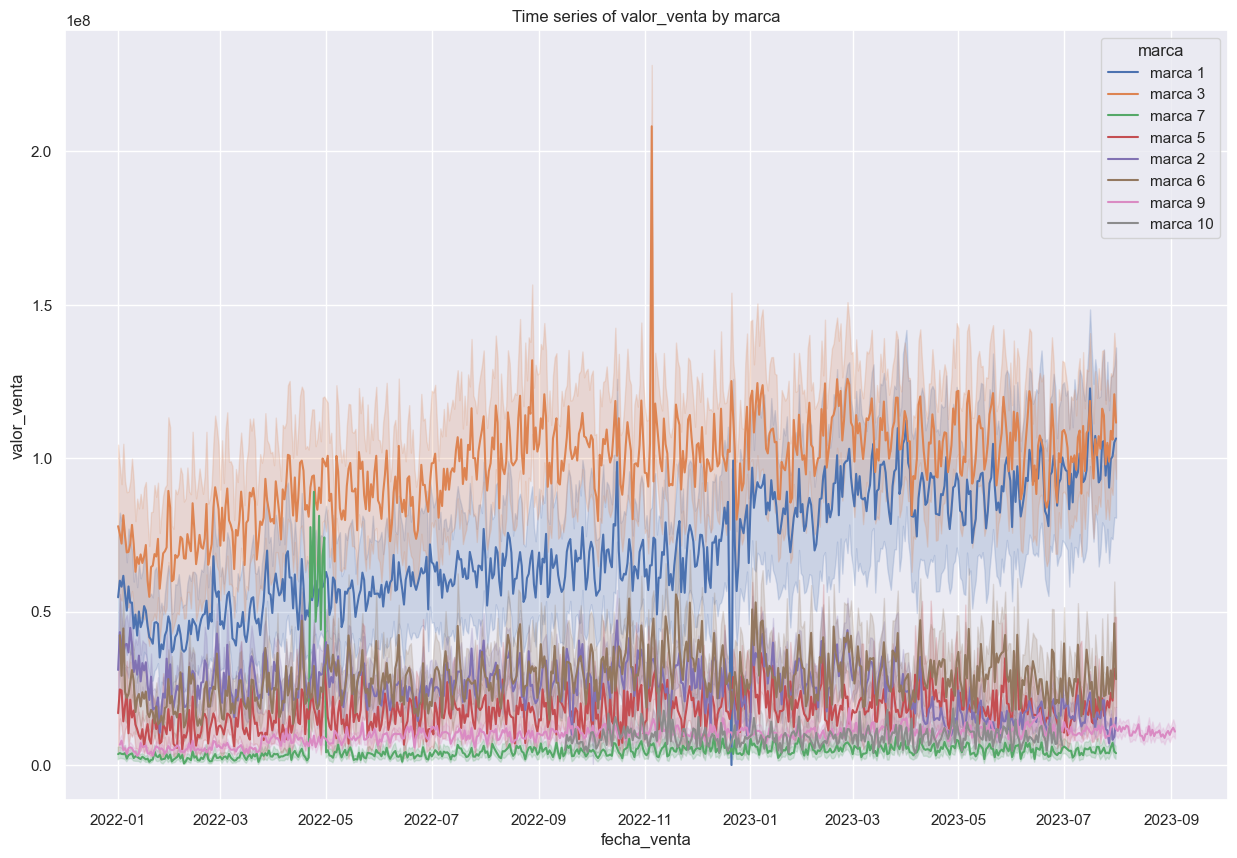

In [134]:
multivariate_utils.plot_time_series(
    df_sales,
    "valor_venta",
    "fecha_venta",
    "marca",
    (15, 10)
)

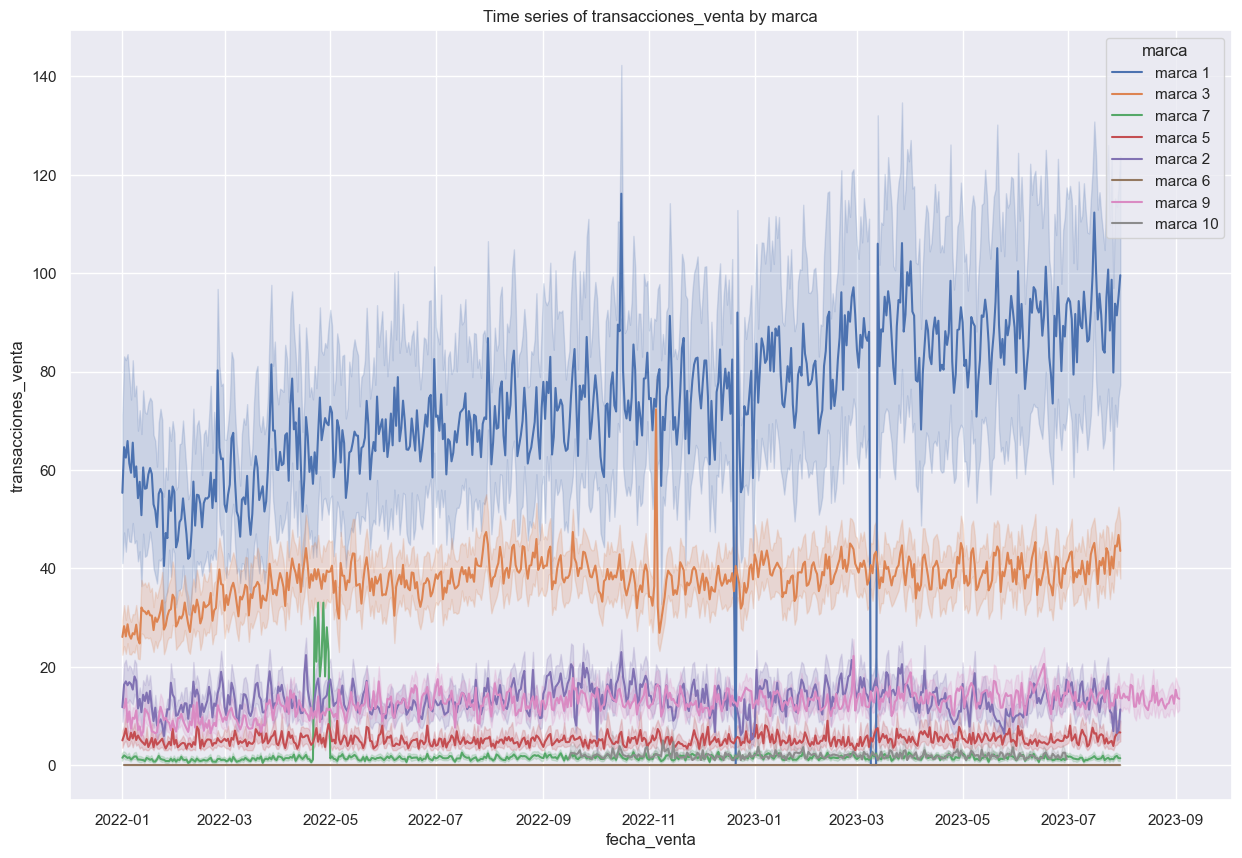

In [135]:
multivariate_utils.plot_time_series(
    df_sales,
    "transacciones_venta",
    "fecha_venta",
    "marca",
    (15, 10)
)

In [136]:
df_sales.groupby("marca").agg({"fecha_venta": ["min", "max"]})

fecha_venta            
                 min         max
marca                           
marca 1   2022-01-01  2023-07-31
marca 10  2022-09-16  2023-06-30
marca 2   2022-01-01  2023-07-31
marca 3   2022-01-01  2023-07-31
marca 5   2022-01-01  2023-07-31
marca 6   2022-01-02  2023-07-31
marca 7   2022-01-01  2023-07-31
marca 9   2022-01-02  2023-09-03

## **Generación del dataset clean_sales**

In [137]:
df_sales.to_parquet(SALES_OUTPUT_FILE, index=False)